# Miguel Angel Mejía Muñoz

## Entrega final CM0896 - Estadística No Paramétrica

## Abstract

El presente notebook explora diversas técnicas de estadística no paramétrica para la metodología de Eigen-faces. Se utilizan técnicas de distinción de poblaciones usando pruebas de profundidad para distinguir si 2 subconjuntos provienen originalmente de la misma población, a su vez que el uso de técnicas no paramétricas para la construcción de las matrices de covarianza utilizadas para hallar los eigen-vectores asociados a las imágenes con el fin de evaluar si estos espacios de representación provenientes de covarianzas robustas presentan mejoras significativas a la hora de realizar clasificaciones de los mismos subconjuntos. Se realizan entonces las pruebas pertenencia basadas en profundidad con los datos representados por estos espacios de menor dimensión. A su vez se realizan técnicas de clasificación y se comparan resultados.

## 1. Introducción

Dentro de las técnicas que se utilizan para el reconocimiento de características faciales, uno de los pioneros es efectivamente el trabajo de Zhao et al. para su metodología de "Eigen-faces", donde se busca reducir el espacio de características de un conjunto de imágenes para simplificar las computaciones de este mismo usando los eigen-vectores de la matriz de covarianza resultante de las imágenes, usando cada pixel como característica. Dado que este conjunto de características corresponde a vectores de la misma dimensión que una imágen, se les llama eigen-faces, dado que estas muestran formas similares a rostros, los cuales corresponden a las características faciales que se abstraen del conjunto. Esto se usa con el fin de reducir el espacio con el cual se define una imágen, dado que cada una puede representarse como una polinomial de cada imágen característica; es decir, se representa cada imágen como los pesos asociados a las eigen-faces del conjunto, el cual es mucho menor que el espacio de pixeles original.

En este notebook se desarrolla esta técnica utilizando distintos métodos del cálculo de la matriz de covarianza de las imágenes, con el fin de determinar mejoras en los procesos de identificación de características faciales y a su vez mejoras en los procesos de clasificación no paramétricos y por medio de máquinas de aprendizaje, estas a su vez paramétricas y no paramétricas.

## 2. Metodología
Se procede entonces a realizar el procedimiento de cálculo de eigen-faces y de realizar las pruebas de pertenencia basadas en profundidad en los datos, con el fin de observar su comportamiento en datos originales y en los datos generados en los sub-espacios.

In [1]:
import sys
sys.path.append('./utils/')

In [2]:
from ImageUtils import *

In [3]:
from sklearn.preprocessing import normalize

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st

In [5]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

Cargamos el conjunto de datos con el que se va a trabajar. Este conjunto consta de 4 subconjuntos concatenados, cada uno de distintas clases. Se tienen 2 subconjuntos con caras de hombres, 1 subconjunto con caras de mujeres, y 1 subconjunto que contiene imágenes de paisajes, flores, y demás, con el fin de adjuntar dentro del conjunto de datos un ruido que corresponda a objetos que no son caras. Este proceso se realiza con el fin de verificar la robustez de las técnicas y su capacidad de representación y abstracción de la información. Todas las imágenes se pasan a escala de grises con el fin de obtener una matriz de $b \times h$ , donde $b$ es el ancho y $h$ es el alto de la imagen.

In [6]:
faces94_male = readFaces94MaleFaces(gray=True)
faces94_female = readFaces94FemaleFaces(gray=True)
faces94_malestaff = readFaces94MaleStaffFaces(gray=True)
landscapes = np.array(readLandsCapeImage(gray=True))

dataset = np.vstack((faces94_male, faces94_female, faces94_malestaff, landscapes))

#class 0: Landscapes
#class 1: male
#class 2: female

labels = np.concatenate((
    np.ones(faces94_male.shape[0]),
    np.full(faces94_female.shape[0], 2),
    np.ones(faces94_malestaff.shape[0]),
    np.zeros(landscapes.shape[0])
))
class_names = ['landscape', 'male', 'female']
dataset_N, height, width = dataset.shape
dataset.shape

(3521, 200, 180)

Con el fin de trabajar el conjunto de datos, pasamos de tener un conjunto de imágenes a un conjunto de vectores, donde la cantidad de características de cada vector corresponde a $b \times h$, base por altura de cada imágen, es decir $200 \times 180 = 36.000$

In [7]:
A = dataset.reshape((dataset_N, height*width))

Como prueba no paramétrica para demostrar que las imágenes de paisajes no corresponden a la misma población que las imágenes de caras, hacemos una prueba de profundidad, donde las profundidades de cada subconjunto respecto a la nube completa de puntos deben corresponder en regresión a una línea recta con $\beta_{0} = 0$ y $\beta_{1} = 1$. Dado este caso, se falla en rechazar la hipótesis nula que ambos subconjuntos vienen de la misma población.

In [8]:
landscapes_start = dataset_N - landscapes.shape[0]

In [9]:
dist_landscapes = dist_from_all(A, landscapes_start, dataset_N, "dist_landscapes.dat")

File already exists, returning file


In [10]:
dist_faces = dist_from_all(A, 0, landscapes_start, "dist_faces.dat")

File already exists, returning file


Al realizar la prueba de profundidad para los datos originales observamos que se obtiene un $\beta_{0} = 0.5216$ y $\beta_{1} = 0.4782$, por lo que se rechaza la hipótesis nula, con lo que concluimos de manera acertada que ambos conjuntos de datos no provienen de la misma población. Esto nos servirá como valor de referencia al realizar la misma prueba al usar la representación de las imágenes en los espacios reducidos por las eigen-faces.

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.484
Model:                            OLS   Adj. R-squared:                  0.484
Method:                 Least Squares   F-statistic:                     3299.
Date:                Tue, 26 May 2020   Prob (F-statistic):               0.00
Time:                        20:29:44   Log-Likelihood:                 34037.
No. Observations:                3521   AIC:                        -6.807e+04
Df Residuals:                    3519   BIC:                        -6.806e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.5216      0.008     62.674      0.0

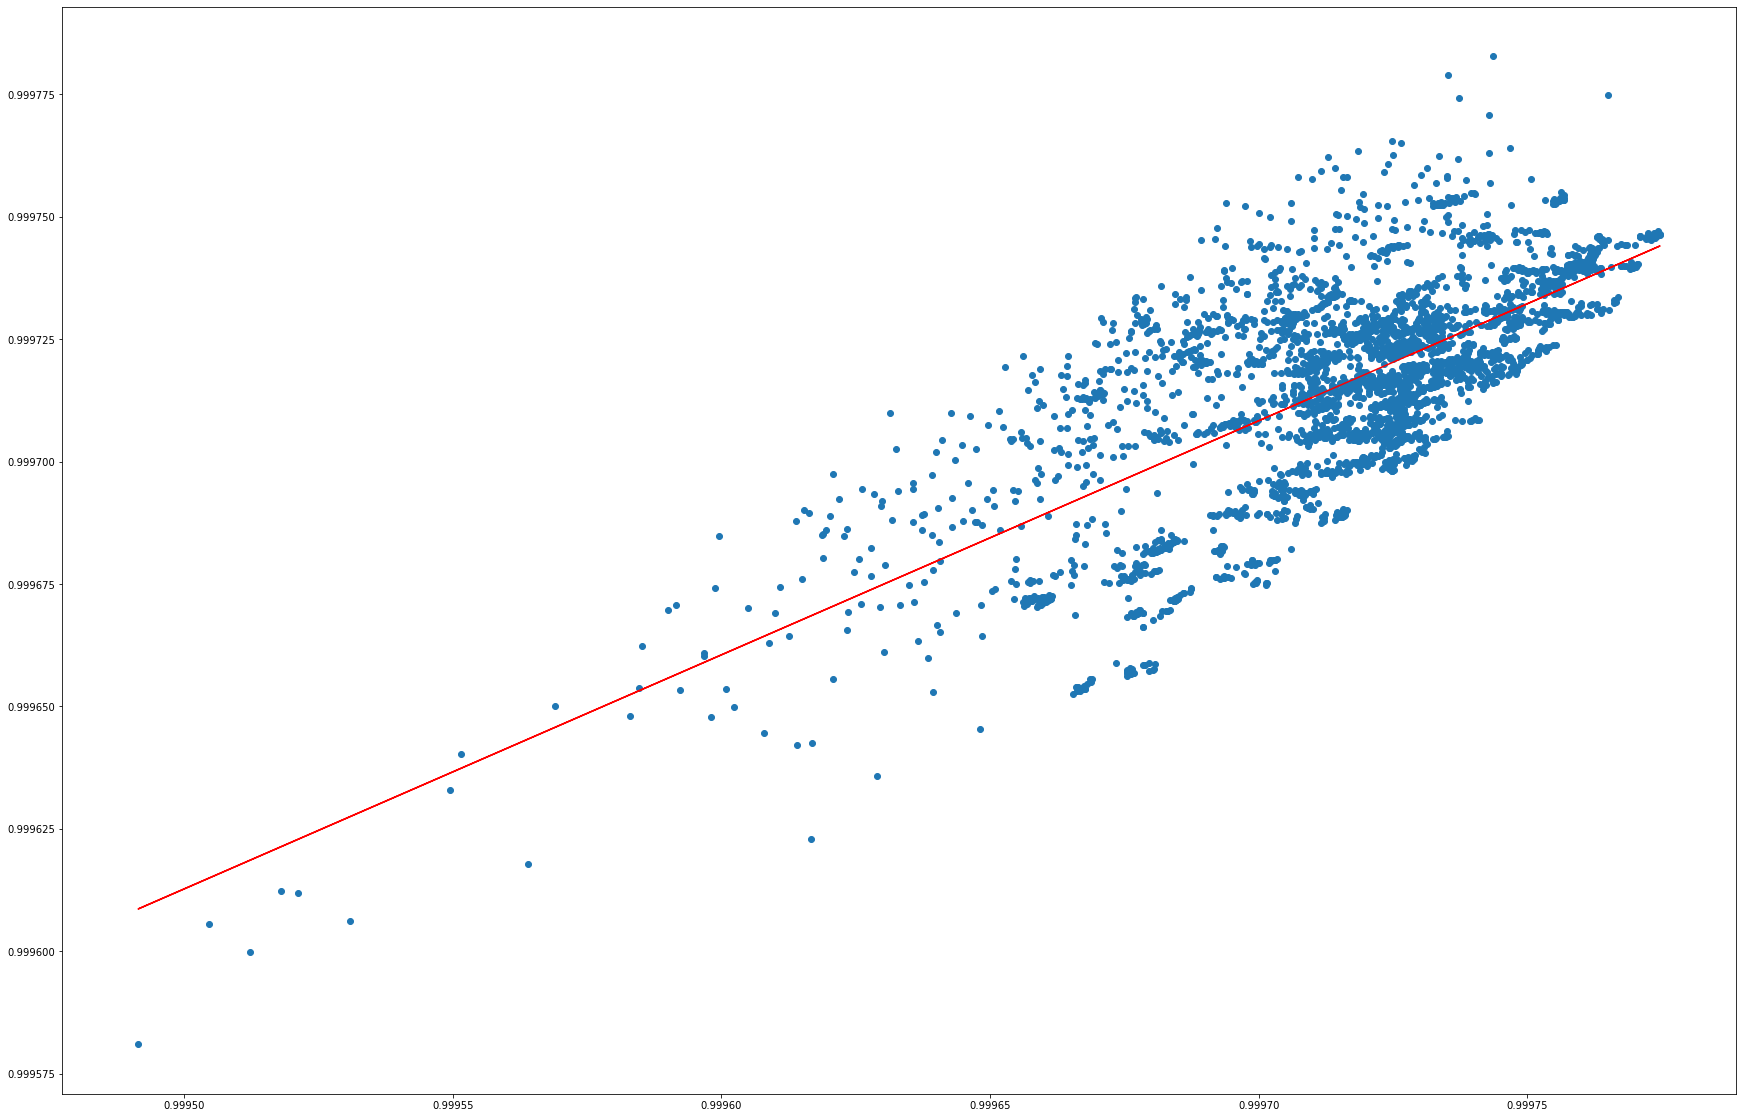

In [11]:
get_depth_test(dist_faces, dist_landscapes)

Calculamos las imágenes media y mediana, con el fin de centrar todo el conjunto de datos respecto a ellas. Utilizamos la media como la versión tradicional del cálculo de las eigen-faces, y la mediana como una opción no paramétrica para centrar el conjunto de imágenes.

In [12]:
median_image = get_median_image(A)

File already exists, returning file


In [13]:
mean_image = A.mean(axis=0)

Esta imagen corresponde a la mediana, aquella que minimiza su distancia hacia todas las demás imágenes dentro del conjunto de datos.

Dada la naturaleza exhaustiva de la computación de las distancias, para agilizar este proceso se realizan paralelizaciones de los cálculos de las distancias, a su vez que se guarda el resultado obtenido en los mismos, con el fin de minimizar el tiempo y obtener la información de manera inmediata en siguientes ejecuciones del notebook. Para re-calcular la imagen mediana, se debe eliminar el archivo que contiene la información de la imagen mediana y permitir que el algoritmo realice de nuevo la búsqueda de la misma.

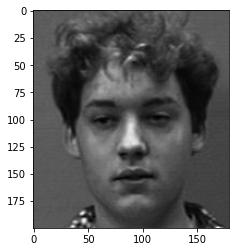

In [14]:
plt.imshow(median_image.reshape(height, width),plt.cm.gray)

El cálculo de la media se usa de manera más dirécta, dando un valor promediado entre pixeles y mostrando la imagen resultante. Cabe aclarar que, dado que la mayoría de imágenes son rostros, la imagen promedio es aquella con las características más resaltantes en todo el conjunto. He aquí la importancia de incluir datos atípicos dentro del conjunto de datos para comprobar la robustez de los métodos alternativos.

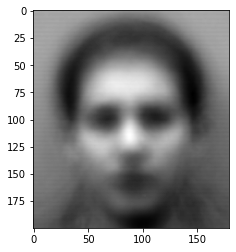

In [15]:
plt.imshow(mean_image.reshape(height, width),plt.cm.gray)

Centramos el conjunto de imágenes respecto a su media y a su mediana, y obtenemos las distancias de todas ellas al centro, con el fin de determinar si existen valores atípicos, que correspondan entonces a aquellas imágenes que no son rostros.

In [16]:
A_mean_center = np.subtract(A, mean_image)

In [17]:
A_median_center = np.subtract(A,median_image)

In [18]:
dist_mean_original = np.linalg.norm(A_mean_center, ord=2, axis=1)
dist_median_original = np.linalg.norm(A_median_center, ord=2, axis=1)

Observamos que la distancia respecto a la media se muestra, aparentemente, más equilibrada. Sin embargo, dadas las características faciales de la imagen media respecto al conjunto total, exacerba las diferencias de iluminación, contraste, e inclusive características faciales de la persona (e.g. Cabello frondoso, piel morena, ligera variación del ángulo de la persona frente a la cámara, etc.). Se observa también una clara asimetría a derechas, esto se debe a la cantidad de imágenes de hombres respecto a las demás clases, y cómo los rasgos de la imagen media parecen corresponder a rasgos predominantemente masculinos, también debido por el desbalance de clases entre las imágenes.

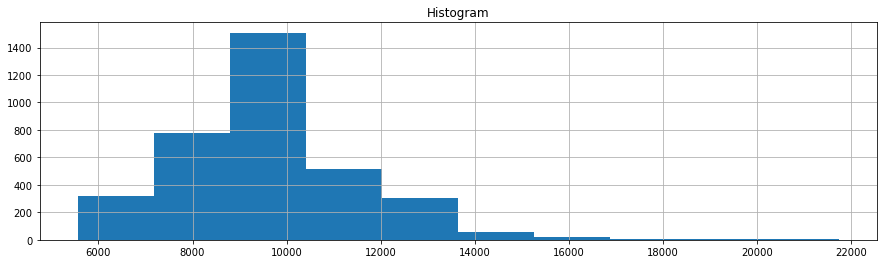

In [19]:
show_histogram(dist_mean_original)

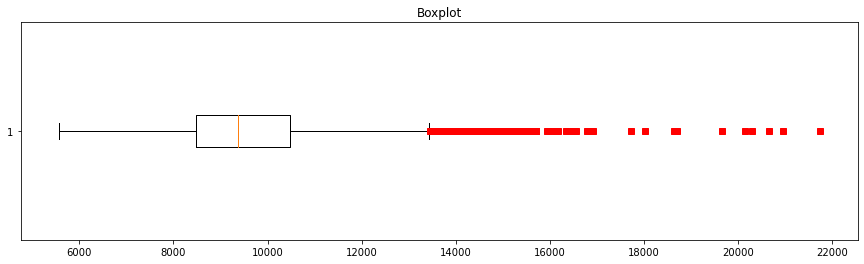

In [20]:
show_boxplot(dist_mean_original)

Podemos observar que las distancias respecto a la mediana se encuentran más centradas. Esto es de esperarse dado que la mediana es aquella imagen que minimiza la distancia respecto a todo el conjunto, por lo que estas se verán más centradas y menos concentradas en la nube de que corresponde a una clase en particular.

Dado que la imagen mediana es una imagen del conjunto, a diferencia de la media que no pertenece a este, los valores atípicos hacia abajo corresponden a personas que son extramadamente similares o con rasgos similares a la mediana. Es decir, pueden ser imágenes del mismo individuo tomadas desde distintos ángulos, por lo que se explica la cercanía de las mismas a la imagen mediana.

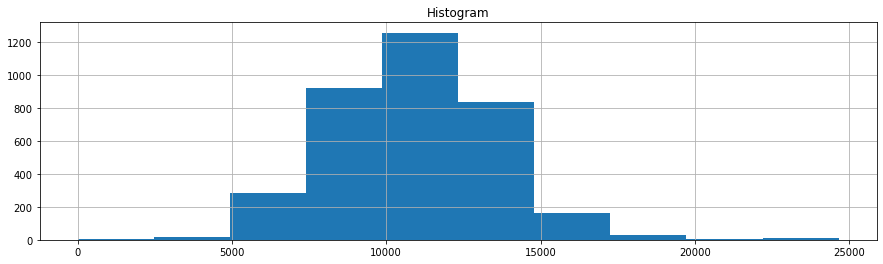

In [21]:
show_histogram(dist_median_original)

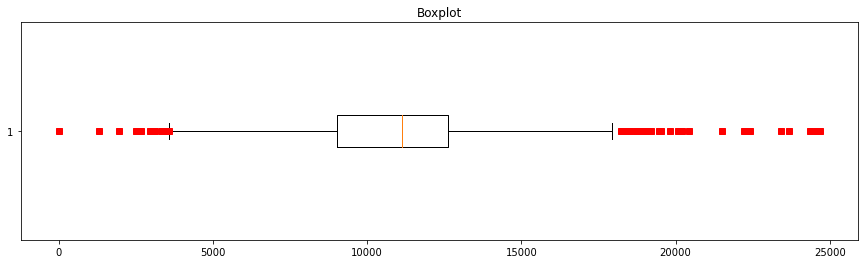

In [22]:
show_boxplot(dist_median_original)

Se procede entonces a calcular las covarianzas del conjunto de imágenes. Utilizamos el método convencional mencionado en el paper de Zhao et al., utilizamos la matriz de covarianza con las imágenes centradas respecto a la mediana, y utilizamos nuestra covarianza robusta basada en la correlación de Spearman y la desviación absoluta mediana respecto a cada pixel.

In [18]:
p_cov = (1/(dataset_N - 1)) * np.matmul(A_mean_center, A_mean_center.T)

In [19]:
p_med_cov = (1/(dataset_N - 1)) * np.matmul(A_median_center, A_median_center.T)

In [20]:
sp_cov = get_spearman_cov(A_median_center)

Get rank matrix
Normalize rank matrix


Dado que el rango de la matriz de covarianza nos dirá la cantidad posible de eigen-valores distintos a 0, ergo la cantidad de dimensiones en las cuales se podrá reducir nuestro conjunto de datos, hallamos el rango para cada una de las matrices de covarianza calculadas.

In [21]:
np.linalg.matrix_rank(p_cov)

467

In [22]:
np.linalg.matrix_rank(p_med_cov)

3499

In [23]:
np.linalg.matrix_rank(sp_cov)

3499

Definimos un porcentaje de representación del $85\%$, es decir, de los eigen-vectores calculados, nos quedaremos con el número de eigen-vectores cuyos eigen-valores correspondan a un $85\%$ de la varianza total del conjunto de imágenes.

In [24]:
desired_percentage = 0.85

Calculamos los eigen-valores y eigen-vectores para cada matriz de covarianza, y obtenemos que para los eigen-vectores obtenidos por la técnica original necesitamos $78$ vectores, $48$ en el caso de la matriz de covarianza respecto a la mediana, y $102$ para la matriz de covarianza robusta.

In [25]:
u, s, v = np.linalg.svd(p_cov)

In [26]:
u_m, s_m, v_m = np.linalg.svd(p_med_cov)

In [27]:
u_sp, s_sp, v_sp = np.linalg.svd(sp_cov)

In [28]:
count_p = get_num_variables_percentage(s, desired_percentage)
count_p_med = get_num_variables_percentage(s_m, desired_percentage)
count_sp = get_num_variables_percentage(s_sp, desired_percentage)

In [29]:
for count in [count_p, count_p_med, count_sp]:
    print("Number of eigenvectors: {}".format(count))

Number of eigenvectors: 78
Number of eigenvectors: 48
Number of eigenvectors: 102


Al calcular los eigen-vectores de las respectivas matrices de covarianza, y multiplicarlos por las matrices de datos centradas, se obtienen los eigen-faces para cada matriz calculada. Estos al tener la misma dimensión que la cantidad de pixeles para cada imágen, en este caso $36.000$ pixeles, estos pueden ser re-dimensionados para representar imágenes que abstraen las características del conjunto de rostros donde se obtienen las matrices de covarianza.

In [30]:
eig_p = normalize(np.dot(A_mean_center.T, u[:, :count_p]), axis=0, norm='l2')
eig_m = normalize(np.dot(A_median_center.T, u_m[:, :count_p_med]), axis=0, norm='l2')
eig_sp = normalize(np.dot(A_median_center.T, u_sp[:, :count_sp]), axis=0, norm='l2')

### Espacio de Eigen-faces para matriz de covarianza original

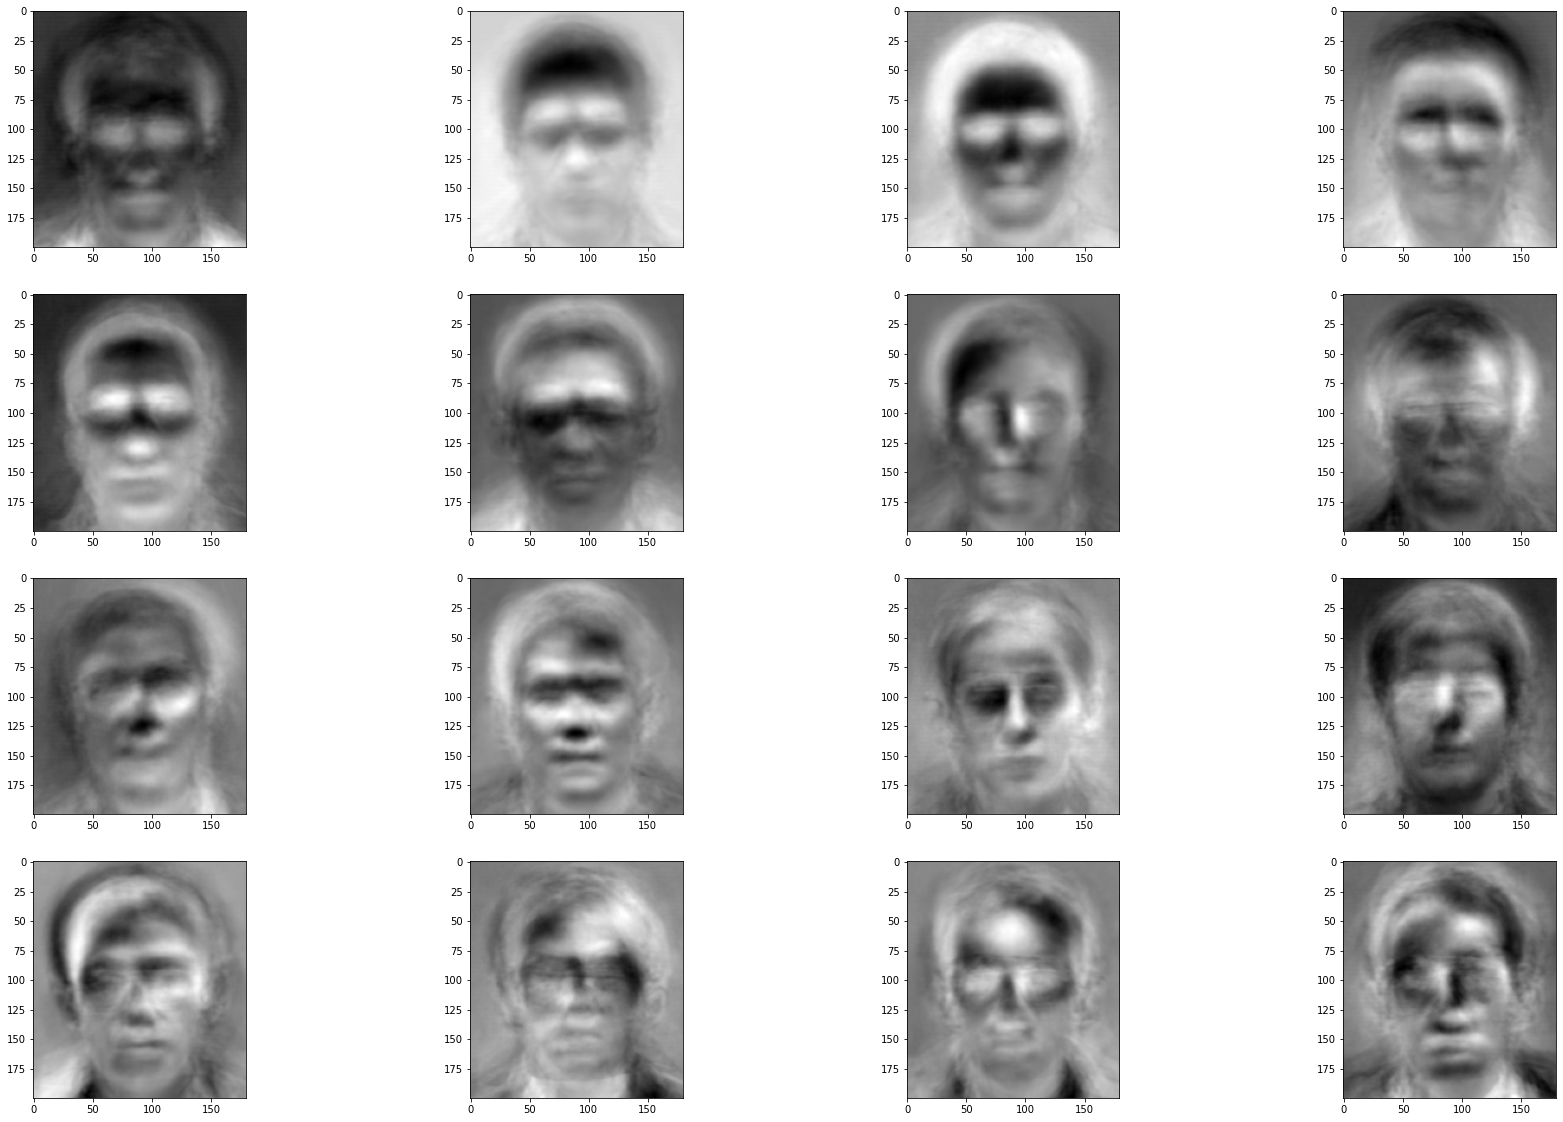

In [31]:
show_eigen_space(eig_p, height, width)

### Espacio de Eigen-faces para matriz de covarianza centrados en mediana

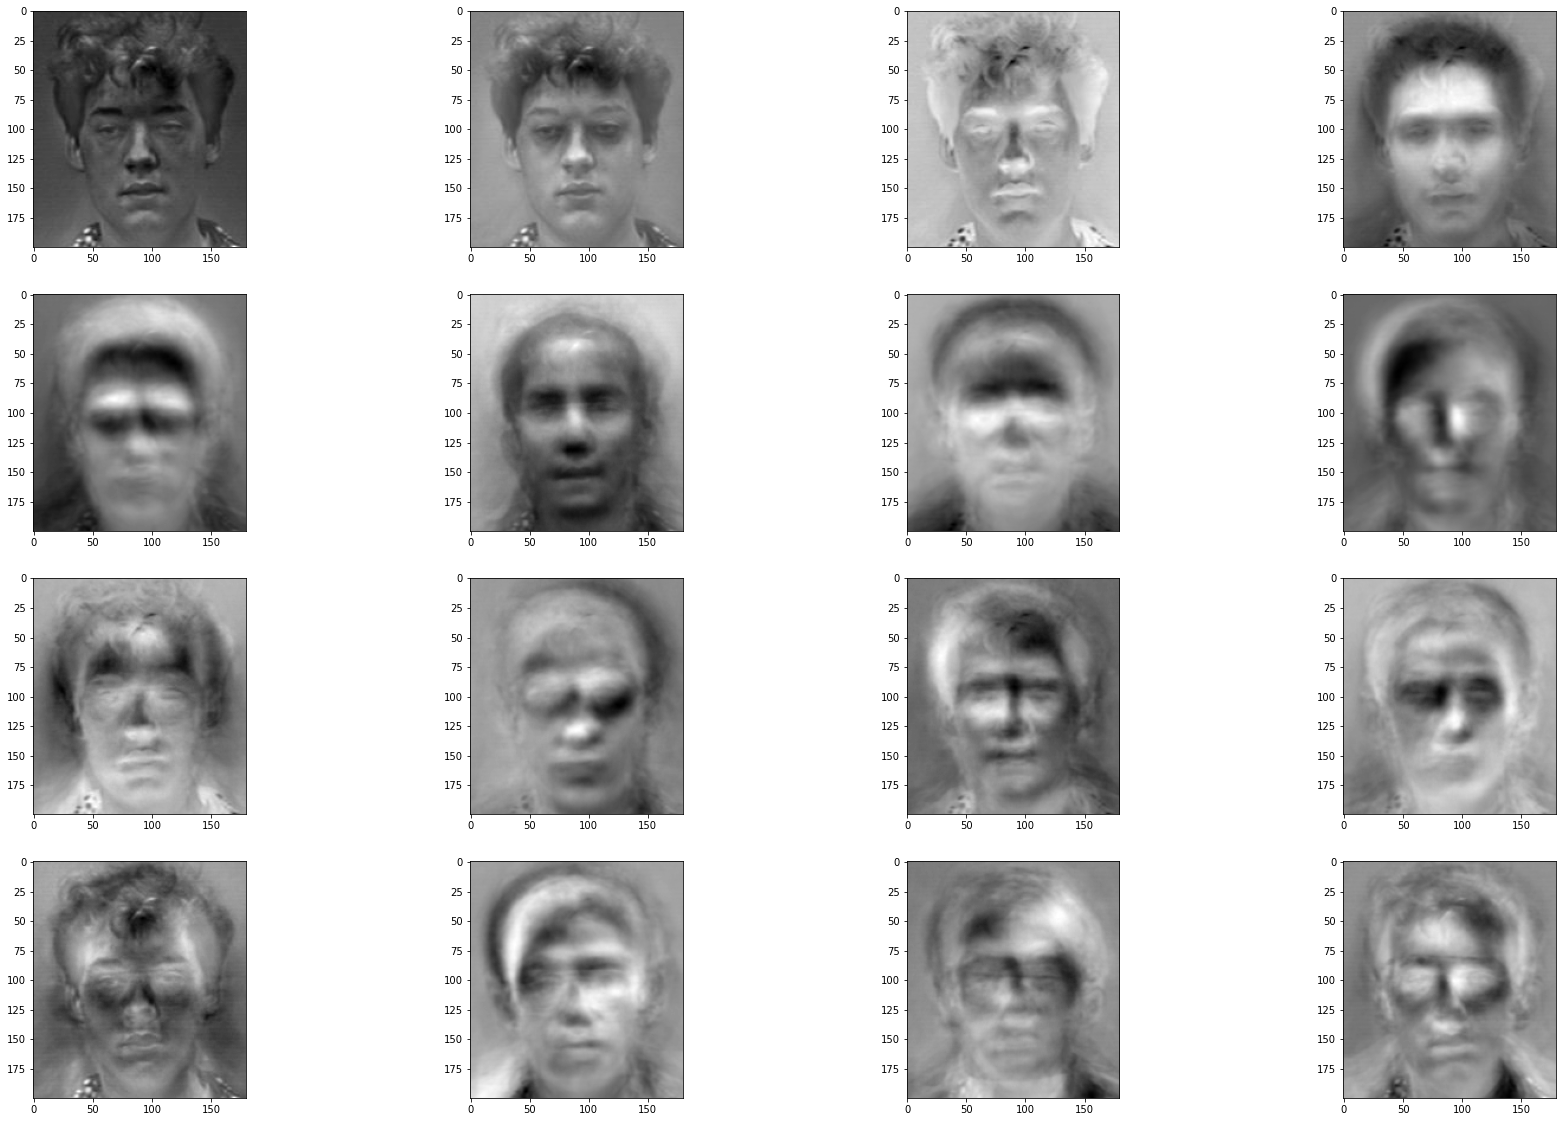

In [32]:
show_eigen_space(eig_m, height, width)

### Espacio de Eigen-faces para matriz de covarianza robusta

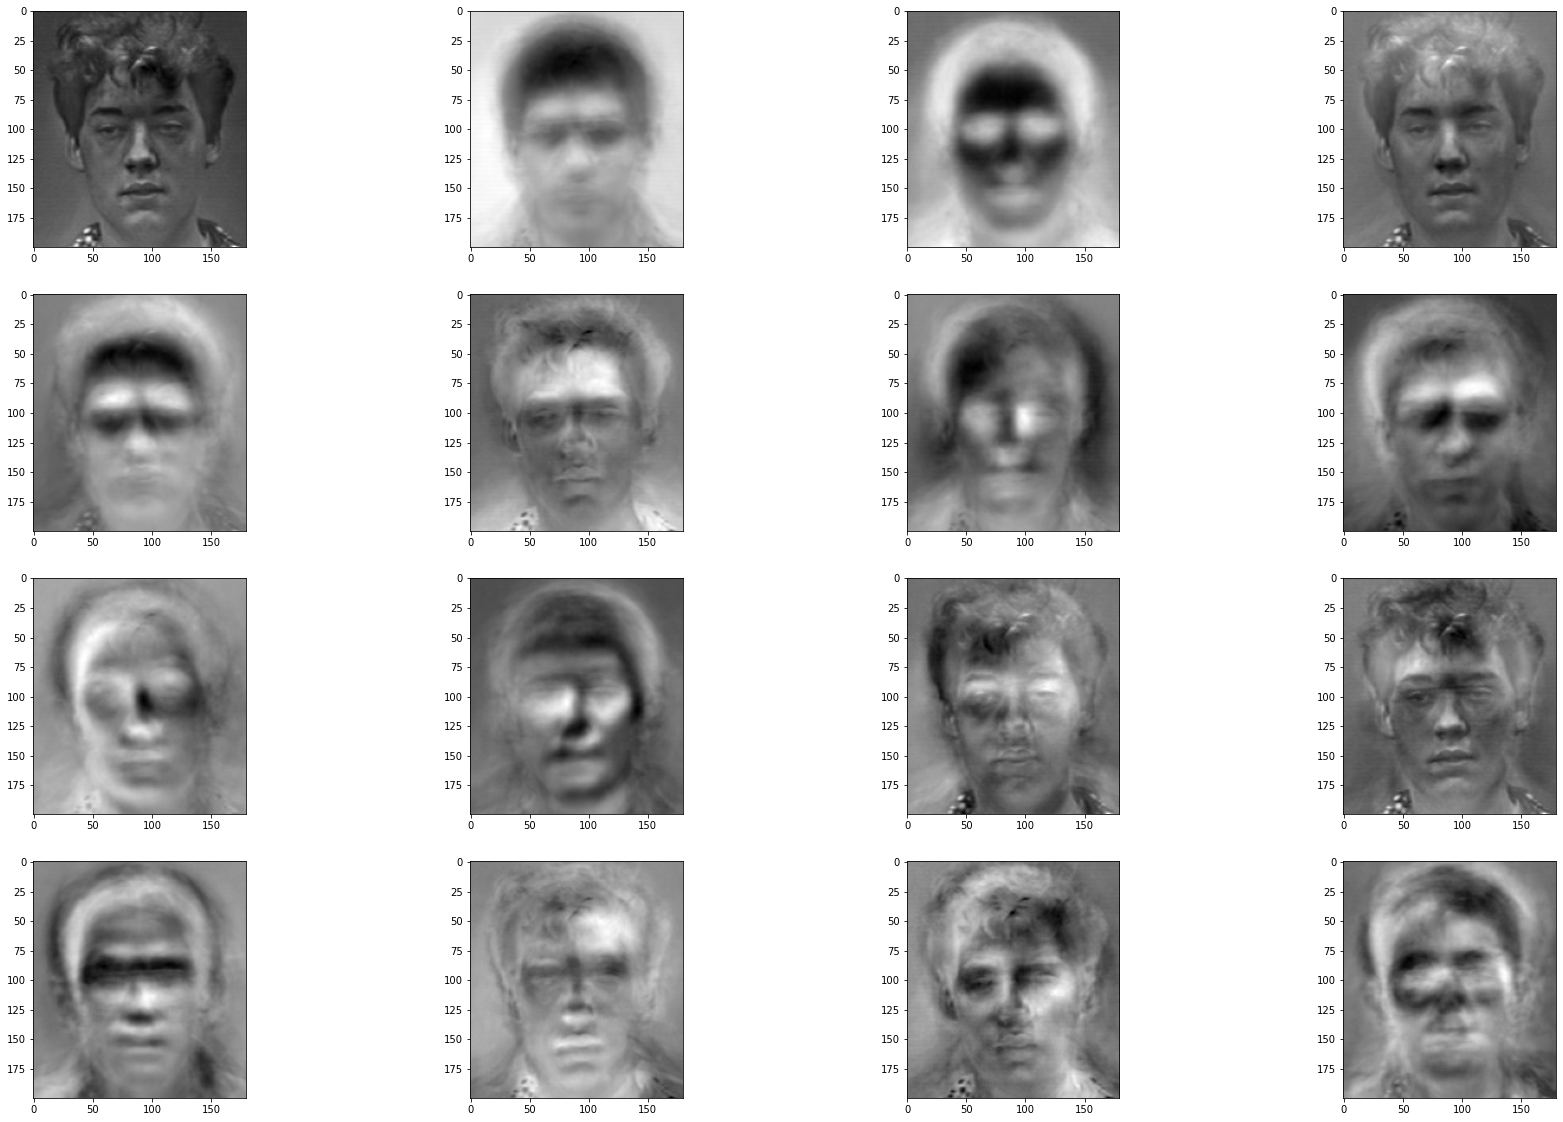

In [33]:
show_eigen_space(eig_sp, height, width)

Dado que se usa un $85\%$ de variabilidad de explicación en cada imágen, la reconstrucción de la misma usando los espacios de eigen-faces calculados anteriormente mostrarán cómo estos codifican la variabilidad de los pixeles. Se muestran las reconstrucciones de los distintos métodos y vemos la viabilidad de éstos para recuperar la información original.

Se usa una imagen de referencia (índice obtenido de manera aleatoria), y se observa cómo ésta es reconstruida usando los distintos espacios de eigen-faces.

In [34]:
ind=2400

In [35]:
img_p = A_mean_center[ind, :]
img_m = A_median_center[ind, :]
img_s = A_median_center[ind, :]

### Imagen original

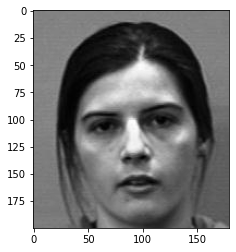

In [36]:
plt.imshow(A[ind,:].reshape(height, width),plt.cm.gray)

### Reconstrucción de la imagen respecto a los espacios de eigen-faces generados

In [37]:
w_p = np.dot(img_p, eig_p)
w_m = np.dot(img_m, eig_m)
w_s = np.dot(img_s, eig_sp)

In [38]:
reconstructed_p = np.dot(w_p, eig_p.T) + mean_image
reconstructed_m = np.dot(w_m, eig_m.T) + median_image
reconstructed_s = np.dot(w_s, eig_sp.T) + median_image

### Reconstrucción de la imagen respecto al espacio de eigen-faces tradicional

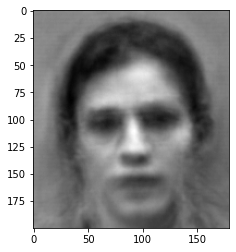

In [39]:
plt.imshow(reconstructed_p.reshape(height, width),plt.cm.gray)

### Reconstrucción de la imagen respecto al espacio de eigen-faces centrado en la mediana

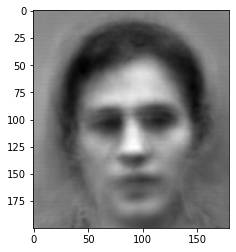

In [40]:
plt.imshow(reconstructed_m.reshape(height, width),plt.cm.gray)

### Reconstrucción de la imagen respecto al espacio de eigen-faces con covarianza robusta

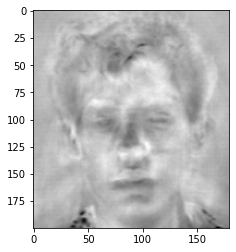

In [41]:
plt.imshow(reconstructed_s.reshape(height, width),plt.cm.gray)

Se puede observar cómo el espacio generado por la matriz de covarianza robusta muestra una reconstrucción sub-óptima, debido a las dependencias generadas entre pixeles por el cálculo de covarianza usando el método de MAD (Median Absolute Deviation) debido a su uso de la mediana para el cálculo de varianza entre imágenes. A pesar de esto, éste método presenta buenos resultados de clasificación, como se verá en la siguiente sección.

Calculamos de nuevo las distancias respecto a la media y a la mediana, con el fin de realizar un comparativo con los resultados obtenidos con los datos originales. Esto nos sirve para determinar la densidad de puntos que se muestran en el espacio reducido, dado que en el espacio original se mostraba una asimetría hacia la derecha en las distancias centradas en la media, debido a que las imágenes tienen una gran cantidad de rostros que corresponden a hombres con respecto a las demás clases.

Convertimos la media y mediana en sus respectivas representaciones. Dado que los espacios están centrados, estas representaciones entonces son el vector de $0$ en todas sus posiciones. Esto es tanto para la media como la mediana en sus respectivos espacios.

In [42]:
mean_w_p = np.dot(mean_image-mean_image, eig_p)
median_w_m = np.dot(median_image-median_image, eig_m)
median_w_s = np.dot(median_image-median_image, eig_sp)

In [43]:
A_w_p = np.matmul(A_mean_center, eig_p)
A_w_m = np.matmul(A_median_center, eig_m)
A_w_s = np.matmul(A_median_center, eig_sp)

In [44]:
dist_p = np.linalg.norm(np.subtract(A_w_p, mean_w_p), ord=2, axis=1)
dist_m = np.linalg.norm(np.subtract(A_w_m, median_w_m), ord=2, axis=1)
dist_s = np.linalg.norm(np.subtract(A_w_s, median_w_s), ord=2, axis=1)

De nuevo observamos que la distancia respecto a la media se muestra, aparentemente, más equilibrada. Al igual que su contraparte en los datos originales las características abstraídas respecto al conjunto total por medio de los eigen-valores, exacerba las diferencias de iluminación, contraste, e inclusive características faciales de la persona. Se observa también una clara asimetría a derechas, esto se debe a la cantidad de imágenes de hombres respecto a las demás clases, tal y como se presenta en el caso para los datos originales.

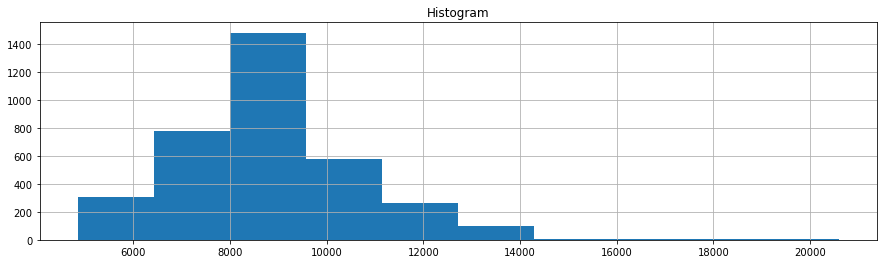

In [45]:
show_histogram(dist_p)

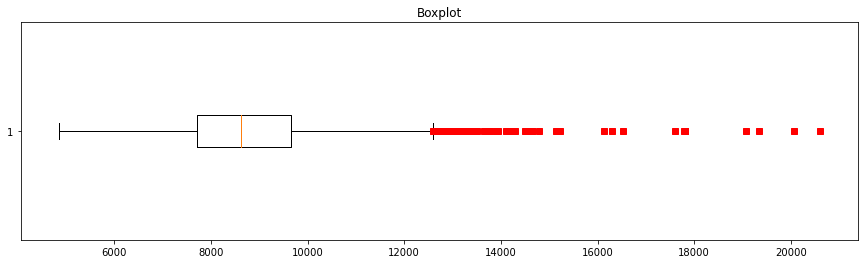

In [46]:
show_boxplot(dist_p)

Similar a su contraparte con datos originales, podemos observar que las distancias respecto a la mediana se encuentran más centradas. Podemos notar también que, dado que la mediana corresponde a una imágen del conjunto de datos, es de esperarse que una de las imágenes haya sido representada por una fila completa de $0$, lo cual se puede observar en el diagrama de caja a continuación.

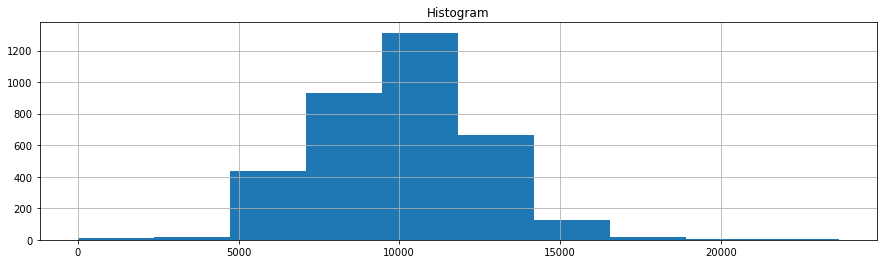

In [47]:
show_histogram(dist_m)

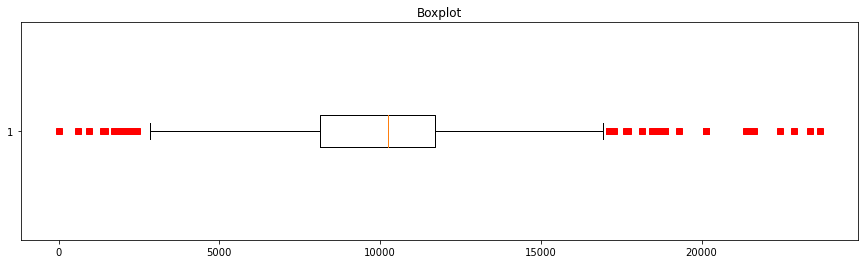

In [48]:
show_boxplot(dist_m)

A pesar de ser una matriz no paramétrica, sorprendentemente presenta rasgos muy asimétricos hacia la derecha. Dado que ésta fue calculada usando la matriz de covarianza robusta, que a su vez usa el valor de **MAD** para determinar el valor de la covarianza entre $X$ y $Y$, implica que la mediana calculada pixel a pixel por éste método presenta menor variabilidad, pero alta asimetría hacia la derecha, por lo que se puede concluir que la media a nivel pixel y la mediana a nivel pixel son similares entre sí.

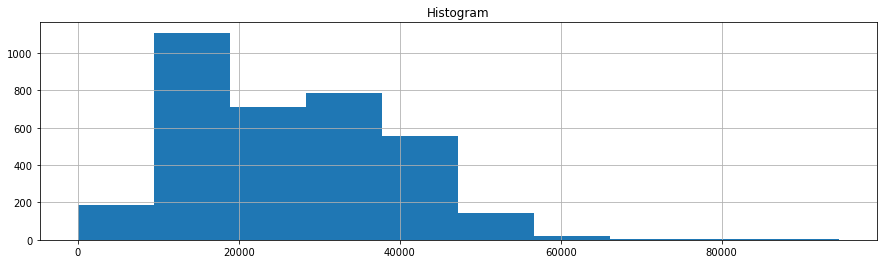

In [49]:
show_histogram(dist_s)

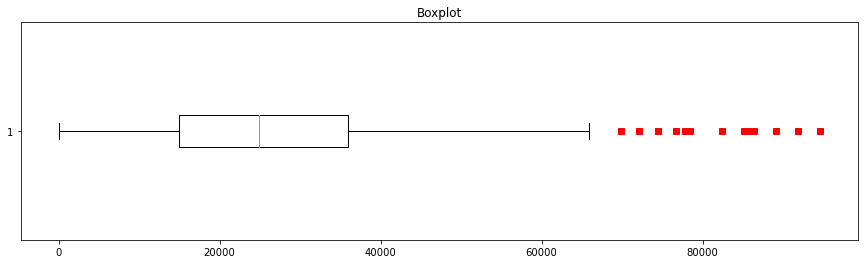

In [50]:
show_boxplot(dist_s)

### Prueba de pertenencia usando profundidad basada en norma

Se realiza la prueba de pertenencia de los subconjuntos usando la profundidad basada en la norma para cada una de las representaciones de los datos en los espacios generados. Se observa que en estos se rechaza la hipótesis nula, dado que en todos se dan al menos 1 de las siguientes 3 condiciones
- $\beta_{0} \neq 0$
- $\beta_{1} \neq 1$
- $r^{2} < 0.9$

Dado que al menos 1 de estas condiciones se cumplen para estos conjuntos de distancias, se rechaza la hipótesis nula y se concluye, tal y como su contraparte con los datos originales, que estos conjuntos no pertenecen a la misma población.

In [51]:
dist_landscapes_p = dist_from_all(A_w_p, landscapes_start, dataset_N, "dist_landscapes_p.dat")
dist_faces_p = dist_from_all(A_w_p, 0, landscapes_start, "dist_faces_p.dat")

File already exists, returning file
File already exists, returning file


In [52]:
dist_landscapes_m = dist_from_all(A_w_m, landscapes_start, dataset_N, "dist_landscapes_m.dat")
dist_faces_m = dist_from_all(A_w_m, 0, landscapes_start, "dist_faces_m.dat")

File already exists, returning file
File already exists, returning file


In [53]:
dist_landscapes_s = dist_from_all(A_w_s, landscapes_start, dataset_N, "dist_landscapes_s.dat")
dist_faces_s = dist_from_all(A_w_s, 0, landscapes_start, "dist_faces_s.dat")

File already exists, returning file
File already exists, returning file


#### Prueba de pertenencia para datos en espacio obtenido por técnica tradicional de eigen-faces

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.396
Model:                            OLS   Adj. R-squared:                  0.396
Method:                 Least Squares   F-statistic:                     2306.
Date:                Tue, 26 May 2020   Prob (F-statistic):               0.00
Time:                        03:28:45   Log-Likelihood:                 32506.
No. Observations:                3521   AIC:                        -6.501e+04
Df Residuals:                    3519   BIC:                        -6.500e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.3767      0.013     29.038      0.0

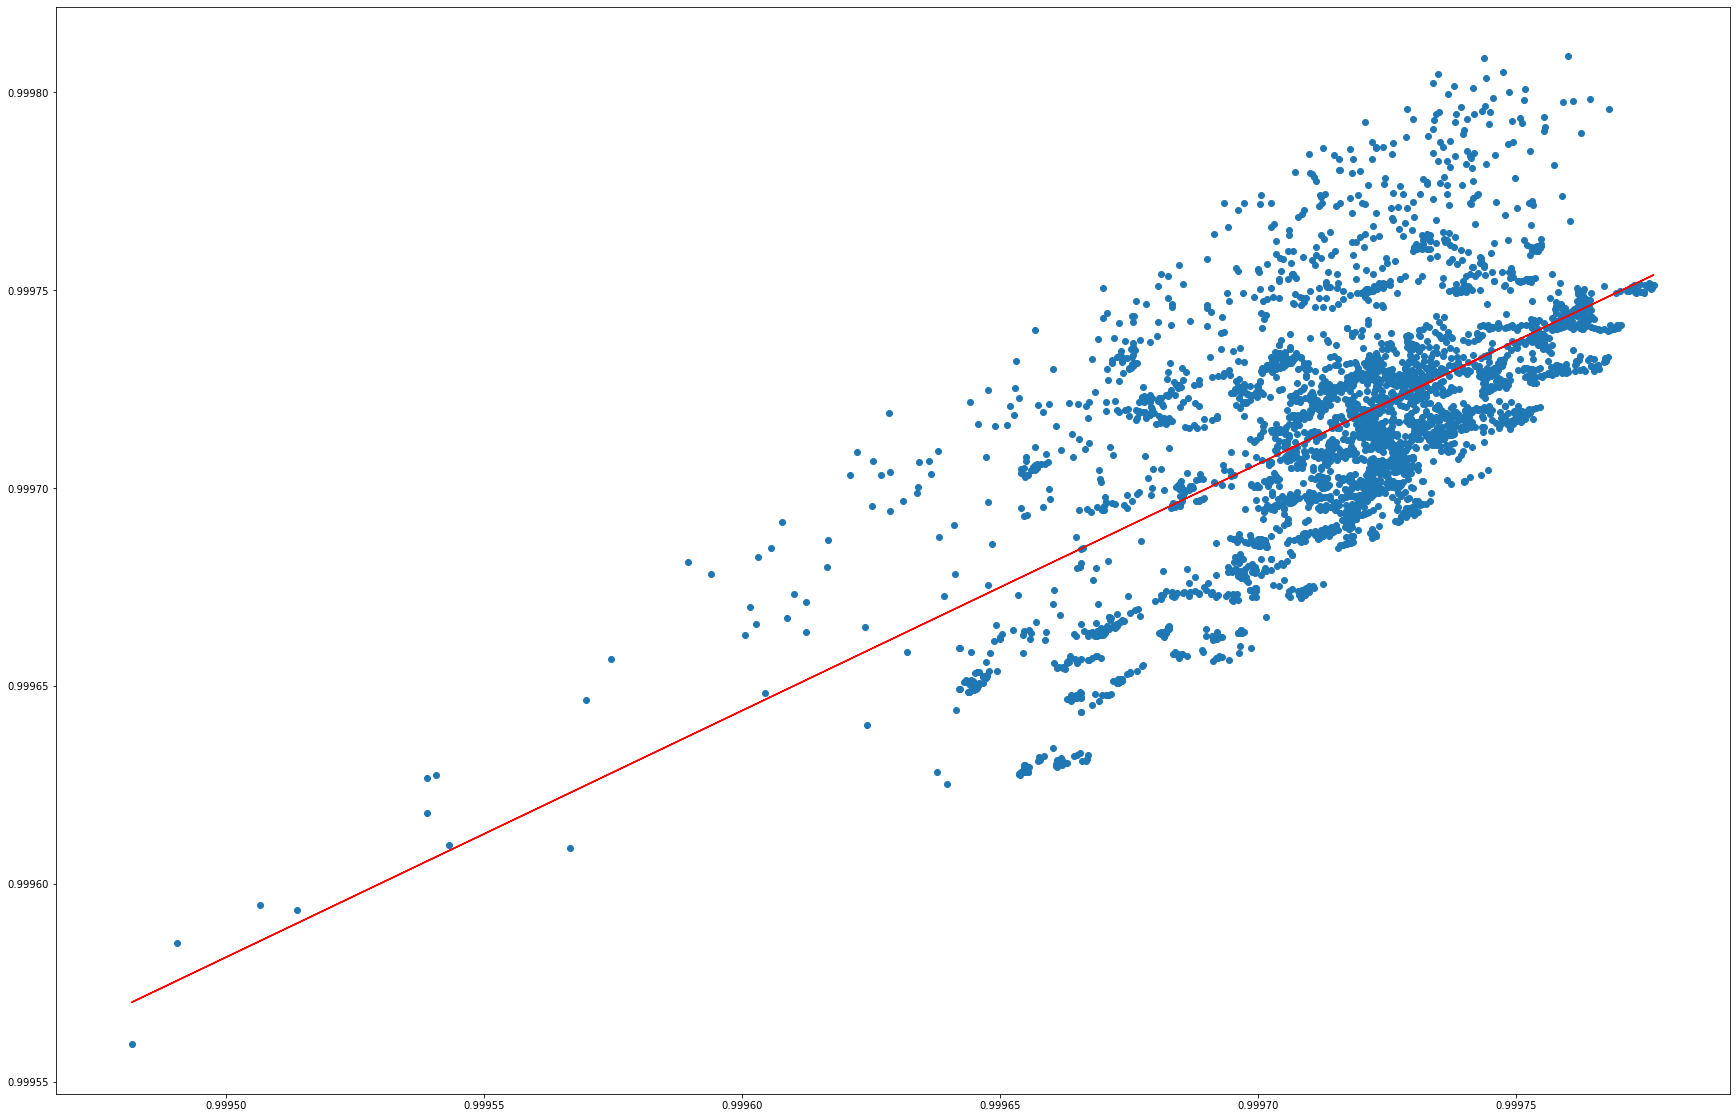

In [54]:
get_depth_test(dist_faces_p, dist_landscapes_p)

#### Prueba de pertenencia para datos en espacio obtenido por técnica usando matriz de covarianza centrada en la mediana

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.383
Model:                            OLS   Adj. R-squared:                  0.383
Method:                 Least Squares   F-statistic:                     2183.
Date:                Tue, 26 May 2020   Prob (F-statistic):               0.00
Time:                        03:28:46   Log-Likelihood:                 32225.
No. Observations:                3521   AIC:                        -6.445e+04
Df Residuals:                    3519   BIC:                        -6.443e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.3665      0.014     27.051      0.0

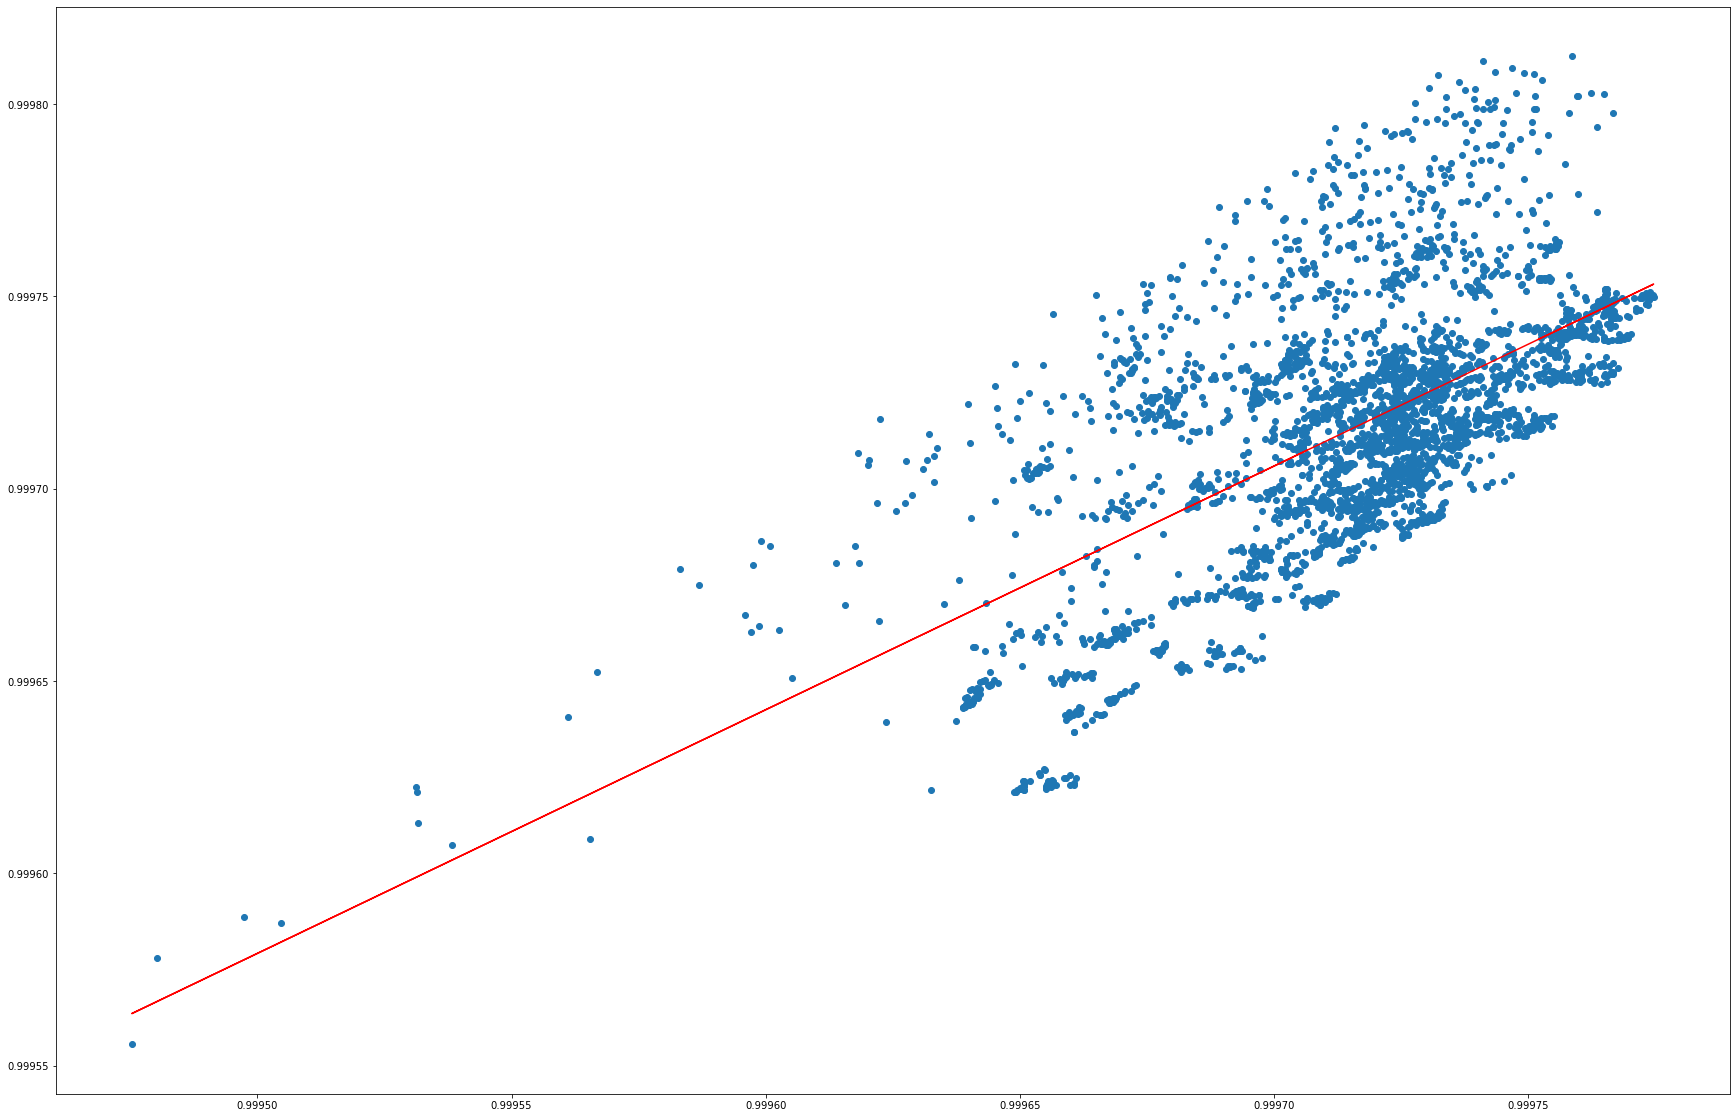

In [55]:
get_depth_test(dist_faces_m, dist_landscapes_m)

#### Prueba de pertenencia para datos en espacio obtenido por técnica usando matriz de covarianza robusta

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.638
Model:                            OLS   Adj. R-squared:                  0.638
Method:                 Least Squares   F-statistic:                     6197.
Date:                Tue, 26 May 2020   Prob (F-statistic):               0.00
Time:                        03:28:46   Log-Likelihood:                 29801.
No. Observations:                3521   AIC:                        -5.960e+04
Df Residuals:                    3519   BIC:                        -5.958e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0657      0.014     -4.851      0.0

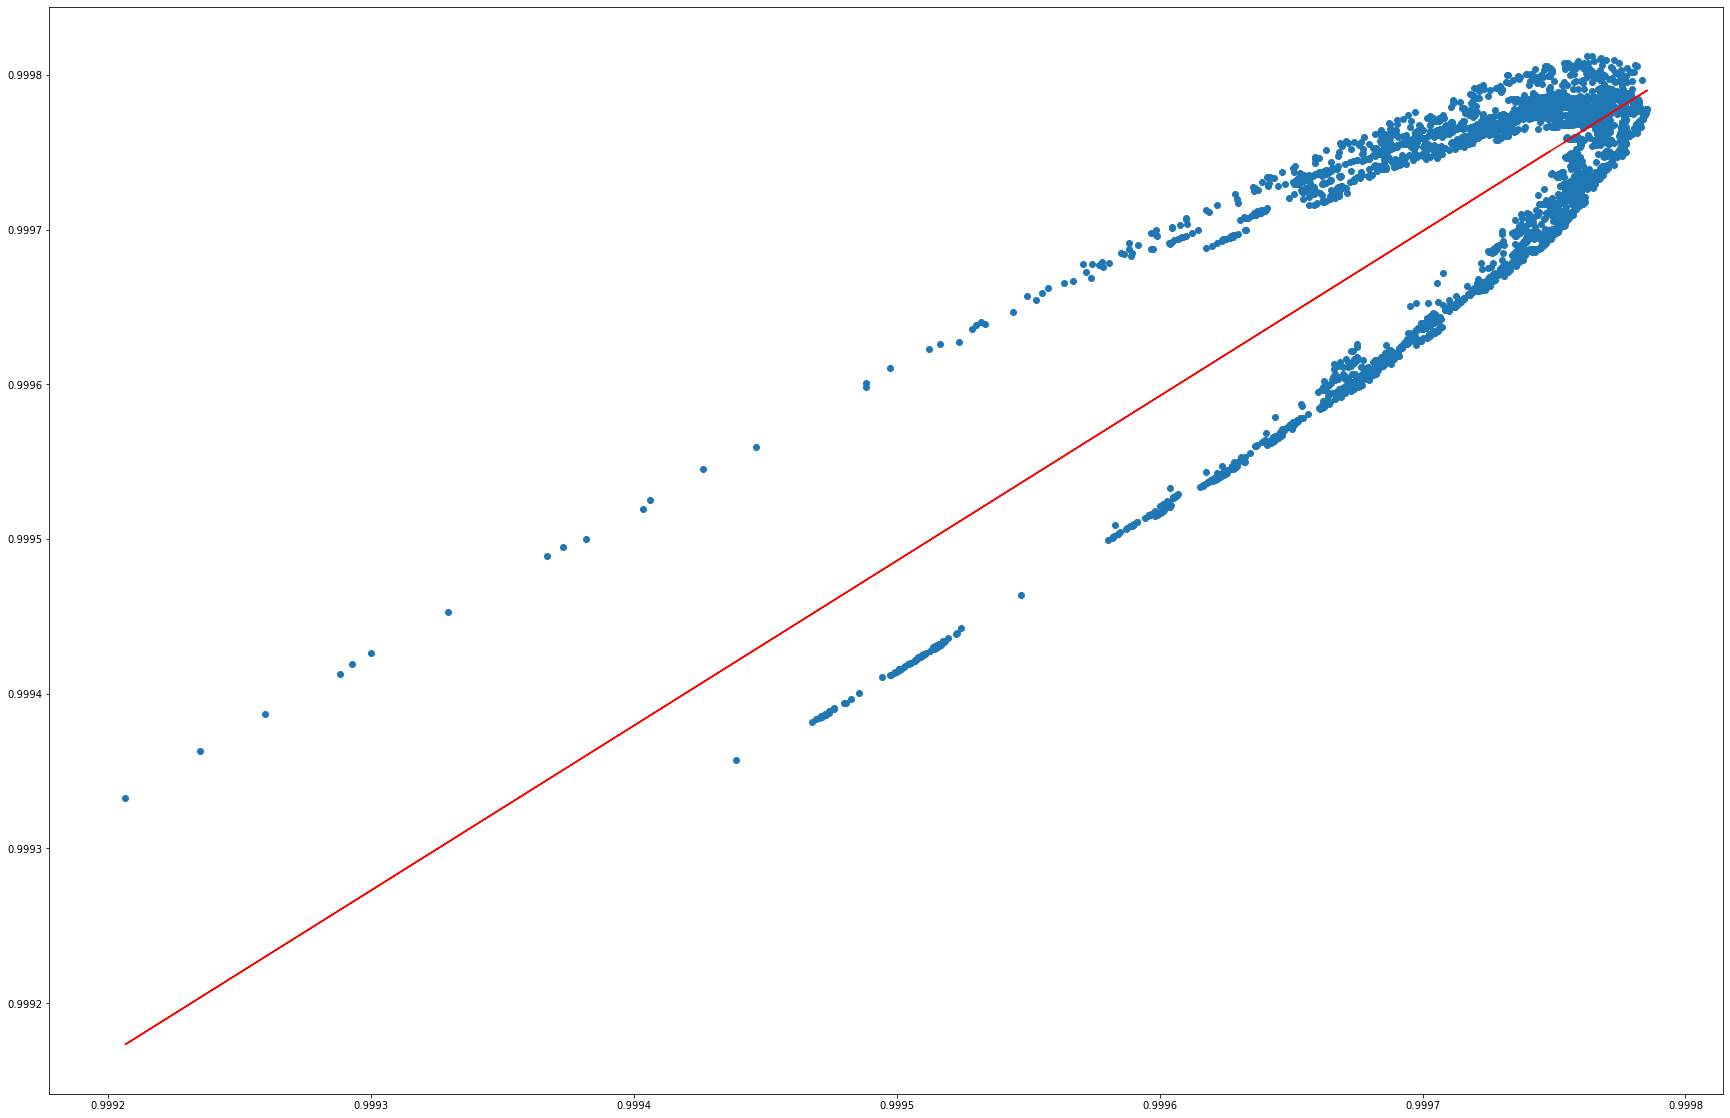

In [56]:
get_depth_test(dist_faces_s, dist_landscapes_s)

A pesar que en la última prueba se observa una relación subyacente entre las distancias de cada subconjunto a la nube de puntos original, aún se puede apreciar que se rechaza la hipótesis nula dado que el valor del ajuste no es suficientemente alto como para determinar que existe una relación lineal entre los datos, lo cual concuerda con lo que muestra la gráfica anterior.

Esta relación puede darse debido al uso del **MAD** en el cálculo de la matriz de covarianza robusta, el cual crea una relación entre las distancias debido a que la mediana pixel a pixel es menos probable que sea susceptible a los datos atípicos que pueden encontrarse por la inclusión de imágenes sin rostros en el conjunto de datos.

# 3. Clasificación

Se procede entonces a realizar clasificación de las imágenes, usando algoritmos paramétricos (Discriminante lineal de Fisher, Regresión Logística) y no paramétricos (Bosque Aleatorio). Se realizan las pruebas usando los datos originales, y los datos representados en los 3 espacios correspondientes a las 3 matrices de covarianza calculadas.

### Dividir conjuntos de datos en entrenamiento, validación y prueba

Para poder realizar una comparación concreta respecto a cada algoritmo y cada representación, debemos separar de la misma manera todos los conjuntos de datos en sus respectivos conjuntos de entrenamiento, validación, y prueba. Para ello entonces utilizamos una función que nos permita dividir los índices del conjunto de datos, y obtener los índices a ser usados para entrenamiento, validación, y pruebas.

In [57]:
indices = np.arange(dataset_N)

In [58]:
ind_train, ind_val, ind_test = split_indices(indices, labels)

In [59]:
X_train_original = A[ind_train, :]/255
X_val_original = A[ind_val, :]/255
X_test_original = A[ind_test, :]/255

In [60]:
X_train_p = A_w_p[ind_train, :]
X_val_p = A_w_p[ind_val, :]
X_test_p = A_w_p[ind_test, :]

In [61]:
X_train_m = A_w_m[ind_train, :]
X_val_m = A_w_m[ind_val, :]
X_test_m = A_w_m[ind_test, :]

In [62]:
X_train_s = A_w_s[ind_train, :]
X_val_s = A_w_s[ind_val, :]
X_test_s = A_w_s[ind_test, :]

Usamos estos mismos índices para separar nuestras etiquetas respuesta, con el fin de utilizar estas como base comparativa para todos los modelos y todos los espacios de datos.

In [63]:
y_train = labels[ind_train]
y_val = labels[ind_val]
y_test = labels[ind_test]

Observamos que existe un desbalanceo de clases pronunciado. Esto es de esperarse debido a la cantidad de imágenes que corresponden a los hombres son mucho mayores que las imágenes para las otras dos clases juntas. Se puede observar también que, aunque éste desbalance de clases está presente, los conjuntos de datos de entrenamiento, validación, y prueba son homogéneos en su distribución de datos. Es decir, todos presentan en proporción el mismo desbalance de clases. Esto es por diseño, dado que el algoritmo que usamos para la división de los índices toma en cuenta la proporción de las clases para realizar la división de los datos.

#### Desbalanceo de clases en datos de entrenamiento

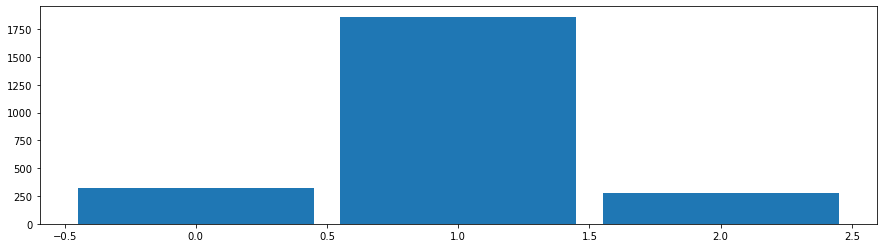

In [64]:
show_items_class(y_train)

#### Desbalanceo de clases en datos de validación

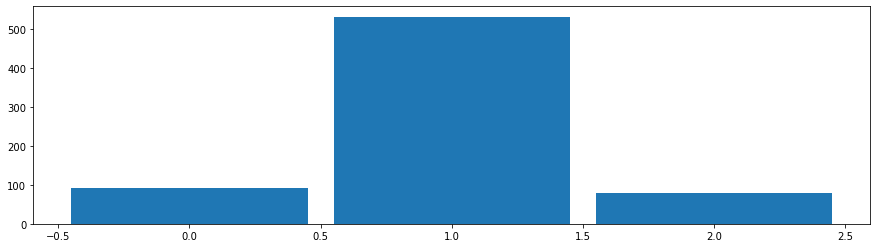

In [65]:
show_items_class(y_val)

#### Desbalanceo de clases en datos de prueba

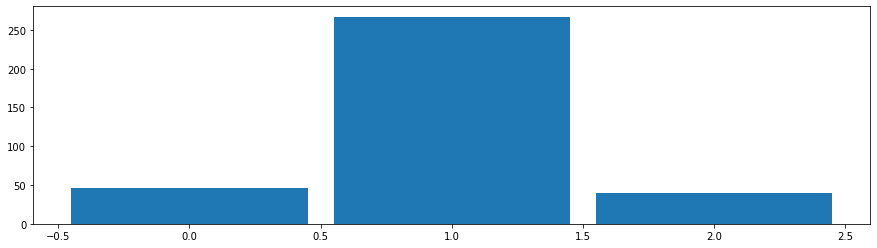

In [66]:
show_items_class(y_test)

### Clasificadores Discriminante Lineal

Como primer acercamiento utilizamos el clasificador lineal de Fisher, el cual se encarga de reducir los datos de tal forma que estos puedan ser divididos por medio de una línea recta en la menor cantidad de dimensiones posibles. Es un clasificador paramétrico dado que debe realizar los cálculos de la matriz de covarianza para realizar esta división del espacio.

In [67]:
original_lda = LinearDiscriminantAnalysis()
mean_center_lda = LinearDiscriminantAnalysis()
median_center_lda = LinearDiscriminantAnalysis()
robust_cov_lda = LinearDiscriminantAnalysis()

#### Entrenamiento clasificadores

In [68]:
original_lda.fit(X_train_original, y_train)
mean_center_lda.fit(X_train_p, y_train)
median_center_lda.fit(X_train_m, y_train)
robust_cov_lda.fit(X_train_s, y_train)

LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage=None,
                           solver='svd', store_covariance=False, tol=0.0001)

#### Clasificador datos originales

Obtenemos entonces los resultados de la clasificación usando el espacio de datos original.

In [69]:
y_val_pred = original_lda.predict(X_val_original)

##### Resultados en conjunto de validación

Accuracy: 0.9644886363636364
Precision for class landscape: 1.0
Precision for class male: 0.9690346083788707
Precision for class female: 0.9080459770114943
              precision    recall  f1-score   support

   landscape       1.00      0.74      0.85        92
        male       0.97      1.00      0.98       532
      female       0.91      0.99      0.95        80

    accuracy                           0.96       704
   macro avg       0.96      0.91      0.93       704
weighted avg       0.97      0.96      0.96       704



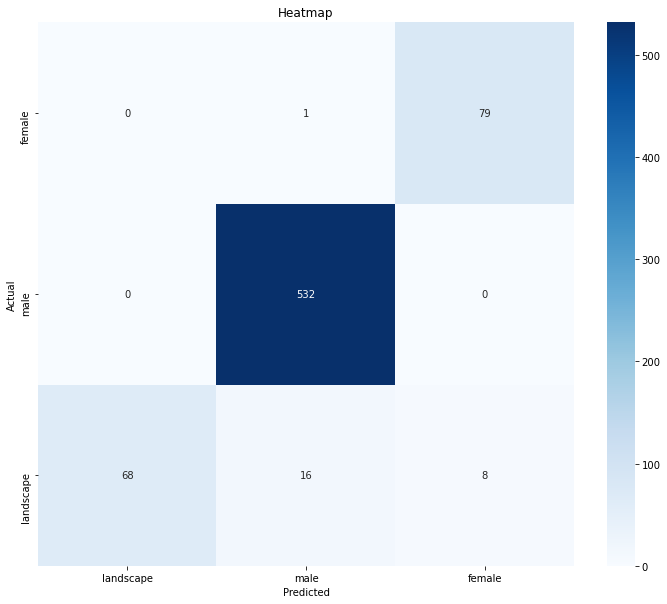

In [70]:
get_classification_results(y_val, y_val_pred,class_names)

In [71]:
y_test_pred = original_lda.predict(X_test_original)

##### Resultados en conjunto de prueba

Accuracy: 0.943342776203966
Precision for class landscape: 1.0
Precision for class male: 0.9468085106382979
Precision for class female: 0.8837209302325582
              precision    recall  f1-score   support

   landscape       1.00      0.61      0.76        46
        male       0.95      1.00      0.97       267
      female       0.88      0.95      0.92        40

    accuracy                           0.94       353
   macro avg       0.94      0.85      0.88       353
weighted avg       0.95      0.94      0.94       353



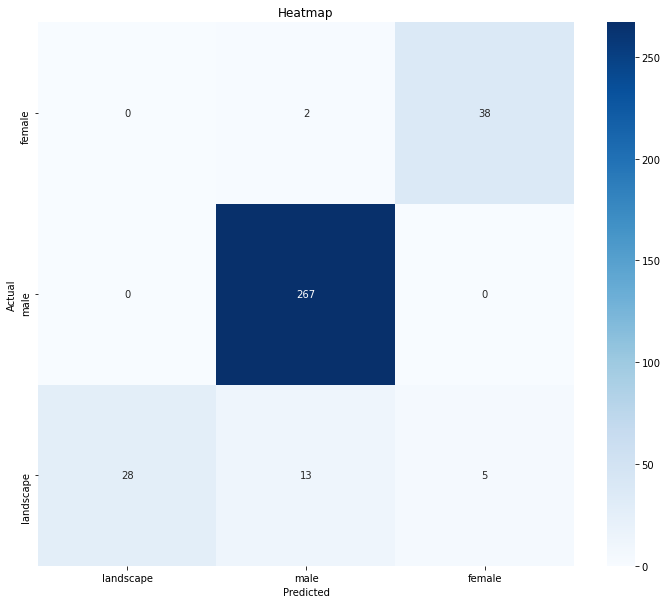

In [72]:
get_classification_results(y_test, y_test_pred,class_names)

#### Clasificador datos centrados en media
Realizamos el mismo proceso con los datos representados usando la técnica original del paper de Zhao, y mostramos los resultados de usar un clasificador paramétrico.

In [73]:
y_val_pred = mean_center_lda.predict(X_val_p)

##### Resultados en conjunto de validación

Accuracy: 0.9517045454545454
Precision for class landscape: 0.9620253164556962
Precision for class male: 0.9581056466302368
Precision for class female: 0.8947368421052632
              precision    recall  f1-score   support

   landscape       0.96      0.83      0.89        92
        male       0.96      0.99      0.97       532
      female       0.89      0.85      0.87        80

    accuracy                           0.95       704
   macro avg       0.94      0.89      0.91       704
weighted avg       0.95      0.95      0.95       704



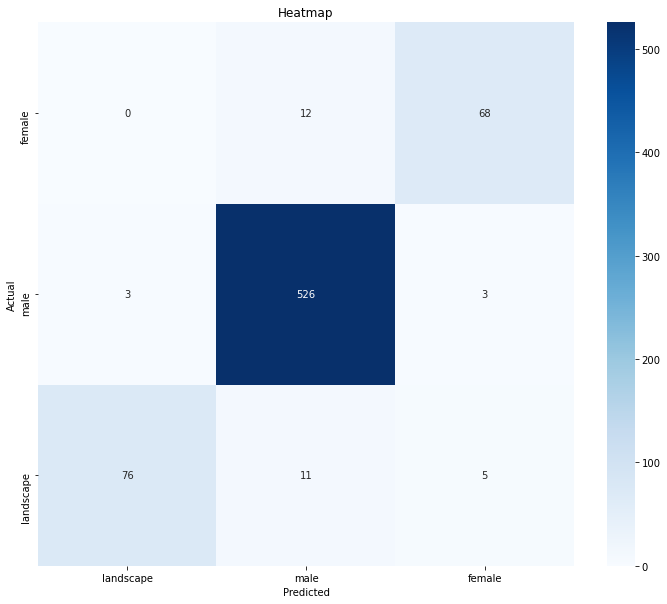

In [74]:
get_classification_results(y_val, y_val_pred,class_names)

In [75]:
y_test_pred = mean_center_lda.predict(X_test_p)

##### Resultados en conjunto de prueba

Accuracy: 0.9575070821529745
Precision for class landscape: 0.972972972972973
Precision for class male: 0.9602888086642599
Precision for class female: 0.9230769230769231
              precision    recall  f1-score   support

   landscape       0.97      0.78      0.87        46
        male       0.96      1.00      0.98       267
      female       0.92      0.90      0.91        40

    accuracy                           0.96       353
   macro avg       0.95      0.89      0.92       353
weighted avg       0.96      0.96      0.96       353



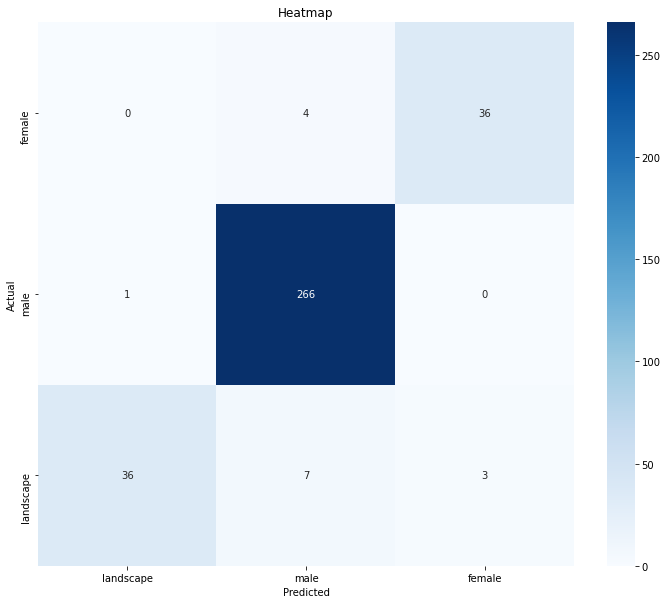

In [76]:
get_classification_results(y_test, y_test_pred,class_names)

##### Clasificador datos centrados en mediana
Realizamos el mismo proceso con los datos representados usando la técnica de covarianza con los datos centrados usando la mediana. Se observan ciertas mejoras en algunas métricas, sin embargo no sobrepasan los resultados obtenidos con los datos originales.

In [77]:
y_val_pred = median_center_lda.predict(X_val_m)

##### Resultados en conjunto de validación

Accuracy: 0.9275568181818182
Precision for class landscape: 0.9506172839506173
Precision for class male: 0.944954128440367
Precision for class female: 0.782051282051282
              precision    recall  f1-score   support

   landscape       0.95      0.84      0.89        92
        male       0.94      0.97      0.96       532
      female       0.78      0.76      0.77        80

    accuracy                           0.93       704
   macro avg       0.89      0.86      0.87       704
weighted avg       0.93      0.93      0.93       704



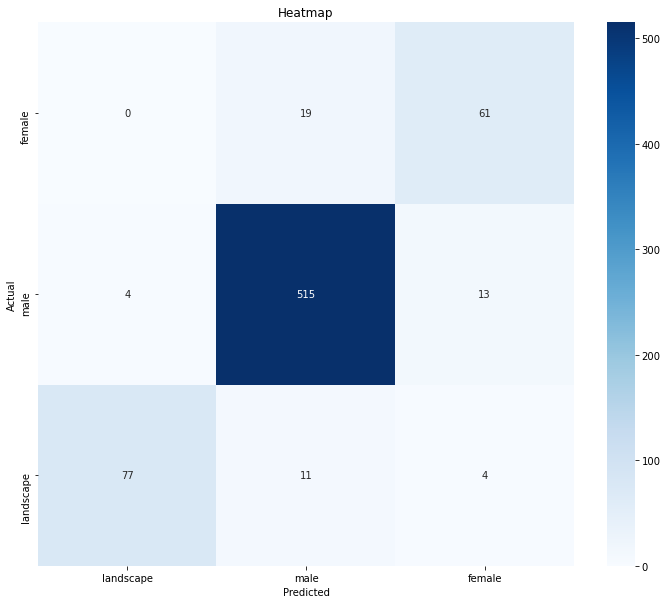

In [78]:
get_classification_results(y_val, y_val_pred,class_names)

In [79]:
y_test_pred = median_center_lda.predict(X_test_m)

##### Resultados en conjunto de prueba

Accuracy: 0.9376770538243626
Precision for class landscape: 0.9722222222222222
Precision for class male: 0.9558823529411765
Precision for class female: 0.8
              precision    recall  f1-score   support

   landscape       0.97      0.76      0.85        46
        male       0.96      0.97      0.96       267
      female       0.80      0.90      0.85        40

    accuracy                           0.94       353
   macro avg       0.91      0.88      0.89       353
weighted avg       0.94      0.94      0.94       353



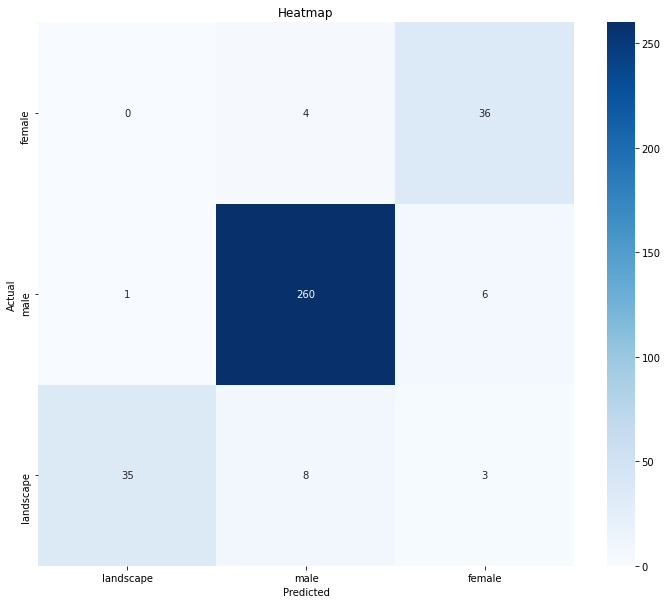

In [80]:
get_classification_results(y_test, y_test_pred,class_names)

#### Clasificador robusto
Realizamos el mismo proceso con los datos representados usando la técnica de covarianza robusta con correlación de Spearman y **MAD**. Similar al caso anterior, se observan ciertas mejoras en algunas métricas, sin embargo no sobrepasan los resultados obtenidos con los datos originales.

In [81]:
y_val_pred = robust_cov_lda.predict(X_val_s)

##### Resultados en conjunto de validación

Accuracy: 0.9488636363636364
Precision for class landscape: 0.9743589743589743
Precision for class male: 0.9512635379061372
Precision for class female: 0.9027777777777778
              precision    recall  f1-score   support

   landscape       0.97      0.83      0.89        92
        male       0.95      0.99      0.97       532
      female       0.90      0.81      0.86        80

    accuracy                           0.95       704
   macro avg       0.94      0.88      0.91       704
weighted avg       0.95      0.95      0.95       704



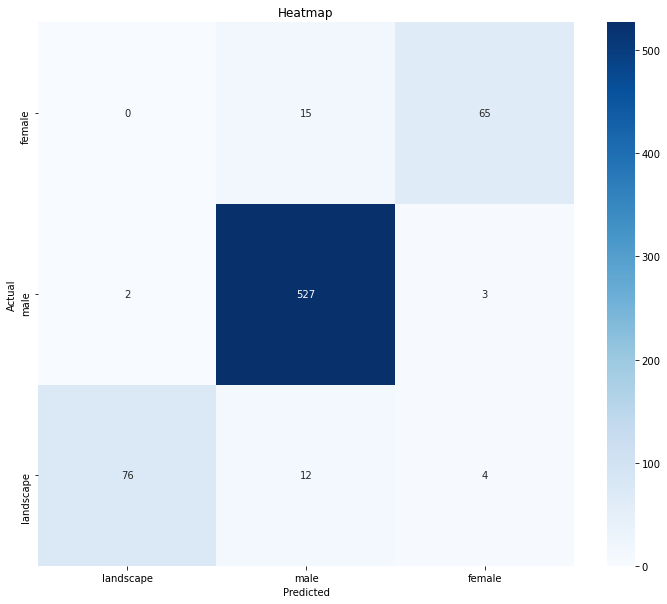

In [82]:
get_classification_results(y_val, y_val_pred,class_names)

In [83]:
y_test_pred = robust_cov_lda.predict(X_test_s)

##### Resultados en conjunto de prueba

Accuracy: 0.9575070821529745
Precision for class landscape: 0.9743589743589743
Precision for class male: 0.9602888086642599
Precision for class female: 0.918918918918919
              precision    recall  f1-score   support

   landscape       0.97      0.83      0.89        46
        male       0.96      1.00      0.98       267
      female       0.92      0.85      0.88        40

    accuracy                           0.96       353
   macro avg       0.95      0.89      0.92       353
weighted avg       0.96      0.96      0.96       353



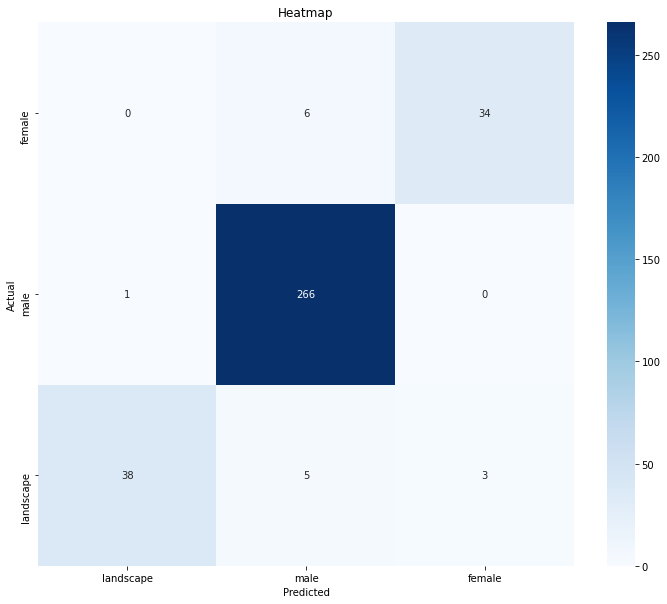

In [84]:
get_classification_results(y_test, y_test_pred,class_names)

### Clasificadores Regresión Logística

Nuestro segundo acercamiento fue usando una clasificación usando regresión logística. Similar a las clasificaciones usando discriminante lineal de Fisher, éste muestra el mejor desempeño sobre los datos originales.

In [85]:
original_log_reg = LogisticRegression(solver='newton-cg', multi_class='multinomial', class_weight="balanced", random_state=0)
mean_center_log_reg = LogisticRegression(solver='newton-cg', multi_class='multinomial', class_weight="balanced", random_state=0)
median_center_log_reg = LogisticRegression(solver='newton-cg', multi_class='multinomial', class_weight="balanced", random_state=0)
robust_cov_log_reg = LogisticRegression(solver='newton-cg', multi_class='multinomial', class_weight="balanced", random_state=0)

#### Entrenamiento clasificadores

In [86]:
original_log_reg.fit(X_train_original, y_train)
mean_center_log_reg.fit(X_train_p, y_train)
median_center_log_reg.fit(X_train_m, y_train)
robust_cov_log_reg.fit(X_train_s, y_train)

C:\Users\mmeji\.conda\envs\cm0896\lib\site-packages\scipy\optimize\linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\mmeji\.conda\envs\cm0896\lib\site-packages\sklearn\utils\optimize.py:204: UserWarning: Line Search failed
  warnings.warn('Line Search failed')
C:\Users\mmeji\.conda\envs\cm0896\lib\site-packages\sklearn\utils\optimize.py:212: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
C:\Users\mmeji\.conda\envs\cm0896\lib\site-packages\sklearn\utils\optimize.py:212: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)


LogisticRegression(C=1.0, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='multinomial', n_jobs=None,
                   penalty='l2', random_state=0, solver='newton-cg', tol=0.0001,
                   verbose=0, warm_start=False)

#### Clasificador datos originales

Se observa un excelente desempeño en las métricas con este conjunto de datos. Esto da a pensar que está manteniendo las relaciones espaciales entre los pixeles y asigna los pesos de manera similar a pixeles que, aunque estén representados en una fila, están espacialmente relacionados.

In [87]:
y_val_pred = original_log_reg.predict(X_val_original)

##### Resultados en conjunto de validación

Accuracy: 0.9829545454545454
Precision for class landscape: 0.9878048780487805
Precision for class male: 0.9851576994434137
Precision for class female: 0.963855421686747
              precision    recall  f1-score   support

   landscape       0.99      0.88      0.93        92
        male       0.99      1.00      0.99       532
      female       0.96      1.00      0.98        80

    accuracy                           0.98       704
   macro avg       0.98      0.96      0.97       704
weighted avg       0.98      0.98      0.98       704



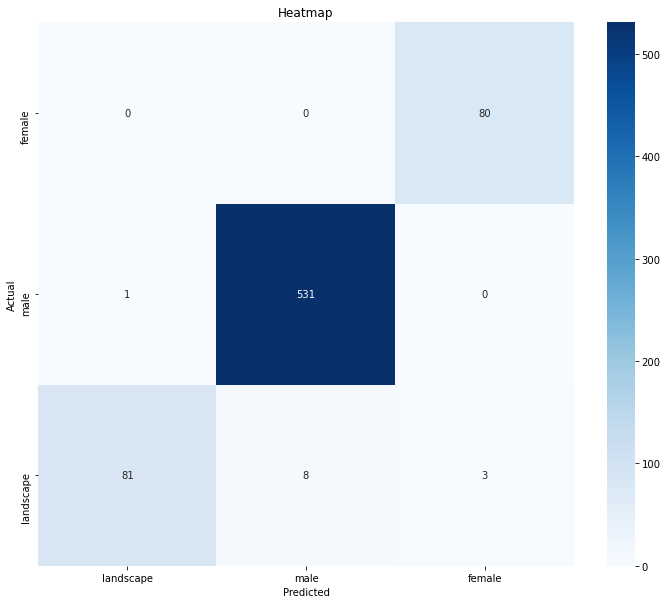

In [88]:
get_classification_results(y_val, y_val_pred,class_names)

In [89]:
y_test_pred = original_log_reg.predict(X_test_original)

##### Resultados en conjunto de validación

Accuracy: 0.9801699716713881
Precision for class landscape: 1.0
Precision for class male: 0.985239852398524
Precision for class female: 0.9302325581395349
              precision    recall  f1-score   support

   landscape       1.00      0.85      0.92        46
        male       0.99      1.00      0.99       267
      female       0.93      1.00      0.96        40

    accuracy                           0.98       353
   macro avg       0.97      0.95      0.96       353
weighted avg       0.98      0.98      0.98       353



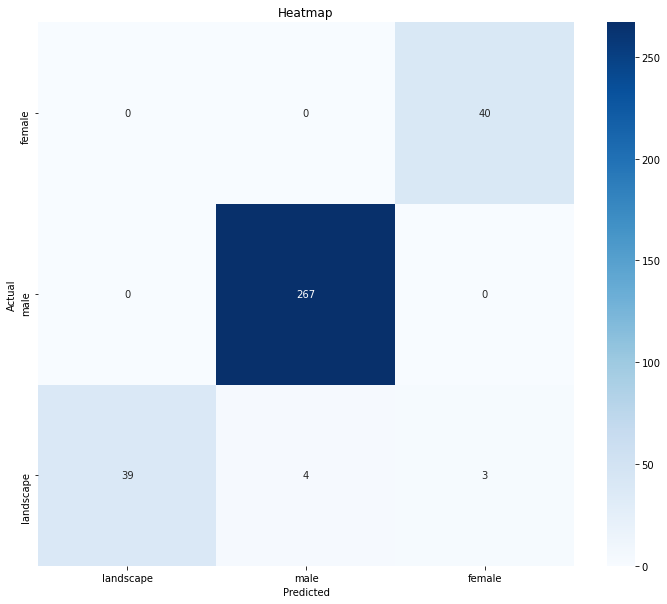

In [90]:
get_classification_results(y_test, y_test_pred,class_names)

#### Clasificador datos centrados en media

Realizamos el mismo proceso con los datos representados usando la técnica original del paper de Zhao, y mostramos los resultados de usar un clasificador paramétrico.

In [91]:
y_val_pred = mean_center_log_reg.predict(X_val_p)

##### Resultados en conjunto de validación

Accuracy: 0.9644886363636364
Precision for class landscape: 0.898876404494382
Precision for class male: 0.9848484848484849
Precision for class female: 0.9080459770114943
              precision    recall  f1-score   support

   landscape       0.90      0.87      0.88        92
        male       0.98      0.98      0.98       532
      female       0.91      0.99      0.95        80

    accuracy                           0.96       704
   macro avg       0.93      0.94      0.94       704
weighted avg       0.96      0.96      0.96       704



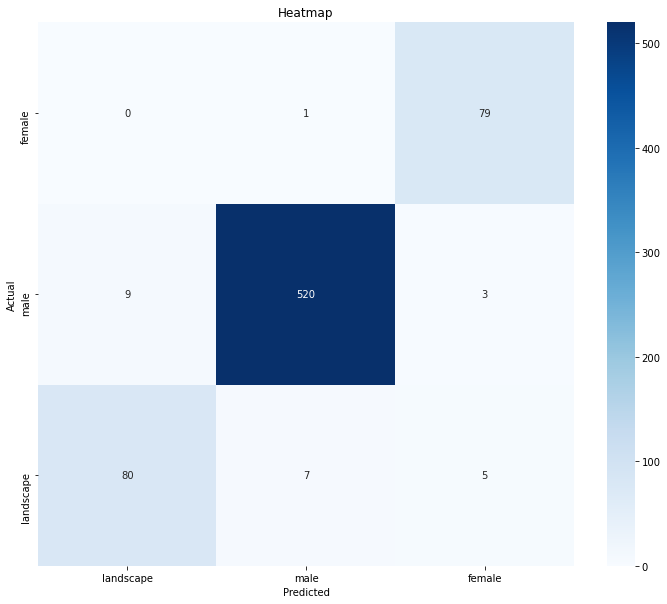

In [92]:
get_classification_results(y_val, y_val_pred,class_names)

In [93]:
y_test_pred = mean_center_log_reg.predict(X_test_p)

##### Resultados en conjunto de prueba

Accuracy: 0.9660056657223796
Precision for class landscape: 0.8913043478260869
Precision for class male: 0.9961685823754789
Precision for class female: 0.8695652173913043
              precision    recall  f1-score   support

   landscape       0.89      0.89      0.89        46
        male       1.00      0.97      0.98       267
      female       0.87      1.00      0.93        40

    accuracy                           0.97       353
   macro avg       0.92      0.96      0.94       353
weighted avg       0.97      0.97      0.97       353



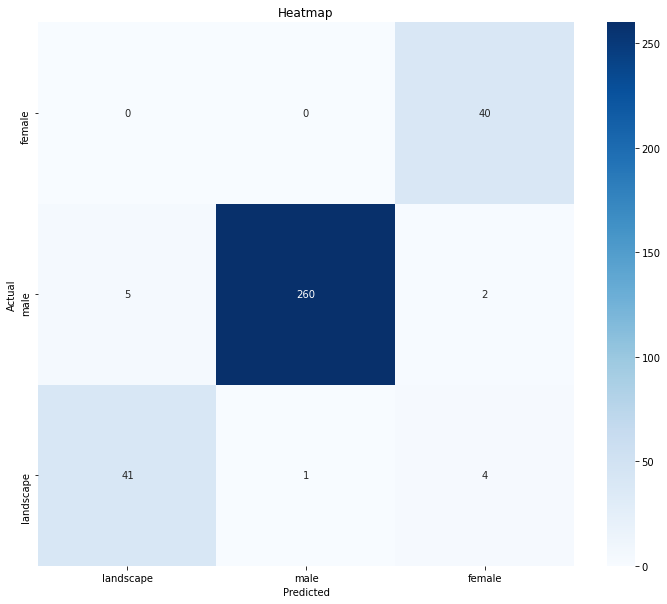

In [94]:
get_classification_results(y_test, y_test_pred,class_names)

#### Clasificador datos centrados en mediana
Realizamos el mismo proceso con los datos representados usando la técnica de covarianza con los datos centrados usando la mediana. Se observan ciertas mejoras en algunas métricas, sin embargo no sobrepasan los resultados obtenidos con los datos originales.

In [95]:
y_val_pred = median_center_log_reg.predict(X_val_m)

##### Resultados en conjunto de validación

Accuracy: 0.9588068181818182
Precision for class landscape: 0.8913043478260869
Precision for class male: 0.9809885931558935
Precision for class female: 0.8953488372093024
              precision    recall  f1-score   support

   landscape       0.89      0.89      0.89        92
        male       0.98      0.97      0.98       532
      female       0.90      0.96      0.93        80

    accuracy                           0.96       704
   macro avg       0.92      0.94      0.93       704
weighted avg       0.96      0.96      0.96       704



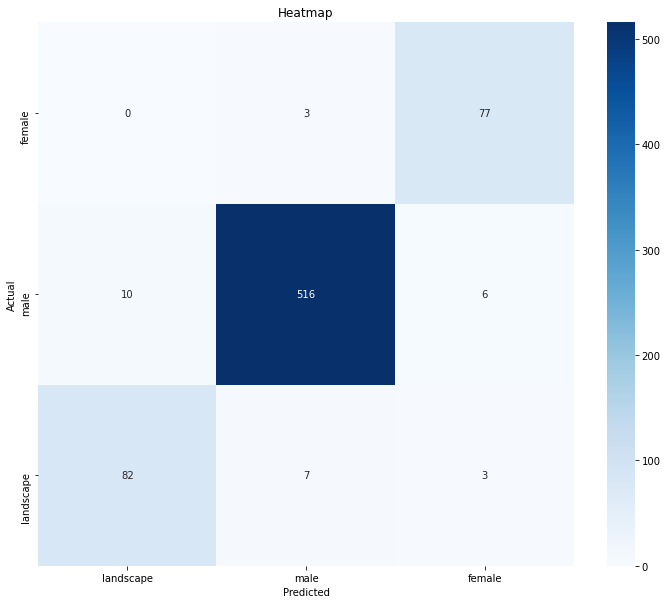

In [96]:
get_classification_results(y_val, y_val_pred,class_names)

In [97]:
y_test_pred = median_center_log_reg.predict(X_test_m)

##### Resultados en conjunto de validación

Accuracy: 0.9518413597733711
Precision for class landscape: 0.9111111111111111
Precision for class male: 0.9846153846153847
Precision for class female: 0.8125
              precision    recall  f1-score   support

   landscape       0.91      0.89      0.90        46
        male       0.98      0.96      0.97       267
      female       0.81      0.97      0.89        40

    accuracy                           0.95       353
   macro avg       0.90      0.94      0.92       353
weighted avg       0.96      0.95      0.95       353



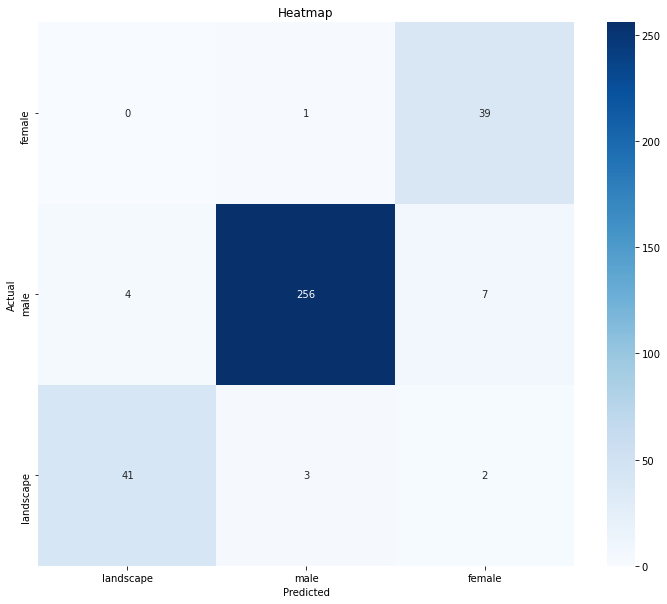

In [98]:
get_classification_results(y_test, y_test_pred,class_names)

#### Clasificador robusto
Realizamos el mismo proceso con los datos representados usando la técnica de covarianza robusta con correlación de Spearman y **MAD**. Similar al caso anterior, se observan ciertas mejoras en algunas métricas, sin embargo no sobrepasan los resultados obtenidos con los datos originales.

In [99]:
y_val_pred = robust_cov_log_reg.predict(X_val_s)

##### Resultados en conjunto de validación

Accuracy: 0.96875
Precision for class landscape: 0.9080459770114943
Precision for class male: 0.9794392523364486
Precision for class female: 0.9634146341463414
              precision    recall  f1-score   support

   landscape       0.91      0.86      0.88        92
        male       0.98      0.98      0.98       532
      female       0.96      0.99      0.98        80

    accuracy                           0.97       704
   macro avg       0.95      0.94      0.95       704
weighted avg       0.97      0.97      0.97       704



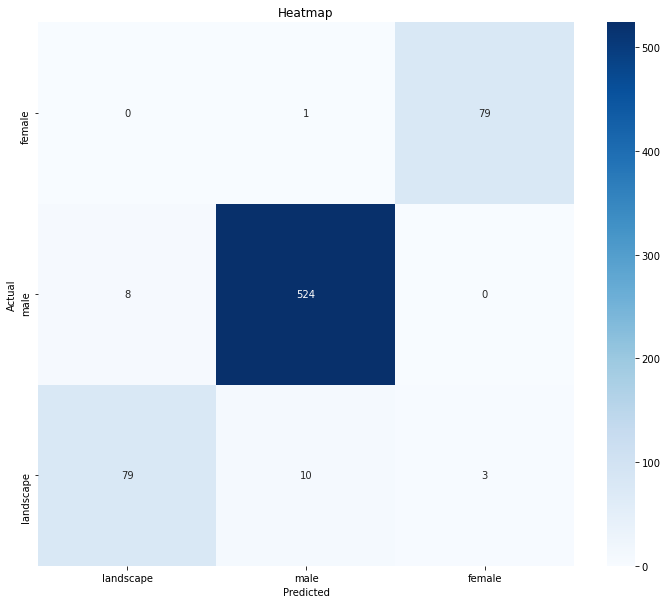

In [100]:
get_classification_results(y_val, y_val_pred,class_names)

In [101]:
y_test_pred = robust_cov_log_reg.predict(X_test_s)

##### Resultados en conjunto de prueba

Accuracy: 0.9660056657223796
Precision for class landscape: 0.8863636363636364
Precision for class male: 0.9812734082397003
Precision for class female: 0.9523809523809523
              precision    recall  f1-score   support

   landscape       0.89      0.85      0.87        46
        male       0.98      0.98      0.98       267
      female       0.95      1.00      0.98        40

    accuracy                           0.97       353
   macro avg       0.94      0.94      0.94       353
weighted avg       0.97      0.97      0.97       353



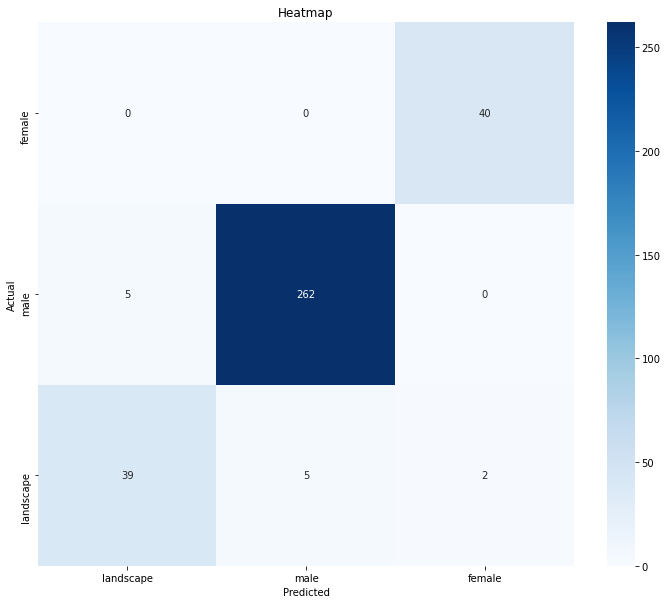

In [102]:
get_classification_results(y_test, y_test_pred,class_names)

### Clasificadores Bosque Aleatorio

Este clasificador mostró un excelente desempeño con los datos representados en los espacios usando las técnicas no paramétricas, particularmente la matriz centrada sobre la mediana. Dado su carácter no paramétrico, da a pensar que está utilizando la información subyacente a los datos diréctamente (e.g. la distribución empírica de los mismos) con el fin de realizar las divisiones dentro de los árboles que se encuentran allí.

In [103]:
original_rand_forest = RandomForestClassifier(n_jobs=-1, random_state=0, class_weight="balanced")
mean_center_rand_forest = RandomForestClassifier(n_jobs=-1, random_state=0, class_weight="balanced")
median_center_rand_forest = RandomForestClassifier(n_jobs=-1, random_state=0, class_weight="balanced")
robust_cov_rand_forest = RandomForestClassifier(n_jobs=-1, random_state=0, class_weight="balanced")

#### Entrenamiento clasificadores

In [104]:
original_rand_forest.fit(X_train_original, y_train)
mean_center_rand_forest.fit(X_train_p, y_train)
median_center_rand_forest.fit(X_train_m, y_train)
robust_cov_rand_forest.fit(X_train_s, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

#### Clasificador datos originales

Similar a sus contrapartes paramétricas, éste clasificador muestra excelentes resultados usando los datos originales. Sin embargo, éstos son superados por sus contrapartes no paramétricas.

In [105]:
y_val_pred = original_rand_forest.predict(X_val_original)

##### Resultados en conjunto de validación

Accuracy: 0.9730113636363636
Precision for class landscape: 0.987012987012987
Precision for class male: 0.968978102189781
Precision for class female: 0.9873417721518988
              precision    recall  f1-score   support

   landscape       0.99      0.83      0.90        92
        male       0.97      1.00      0.98       532
      female       0.99      0.97      0.98        80

    accuracy                           0.97       704
   macro avg       0.98      0.93      0.95       704
weighted avg       0.97      0.97      0.97       704



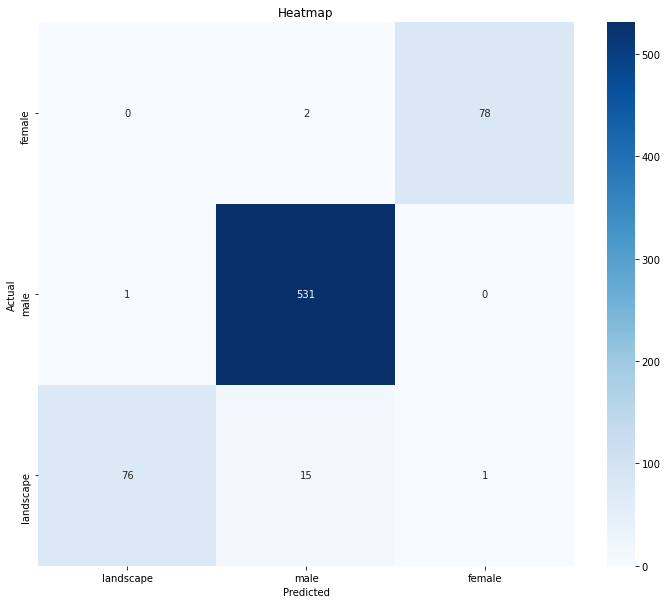

In [106]:
get_classification_results(y_val, y_val_pred,class_names)

In [107]:
y_test_pred = original_rand_forest.predict(X_test_original)

##### Resultados en conjunto de prueba

Accuracy: 0.9745042492917847
Precision for class landscape: 1.0
Precision for class male: 0.9709090909090909
Precision for class female: 0.9743589743589743
              precision    recall  f1-score   support

   landscape       1.00      0.85      0.92        46
        male       0.97      1.00      0.99       267
      female       0.97      0.95      0.96        40

    accuracy                           0.97       353
   macro avg       0.98      0.93      0.95       353
weighted avg       0.98      0.97      0.97       353



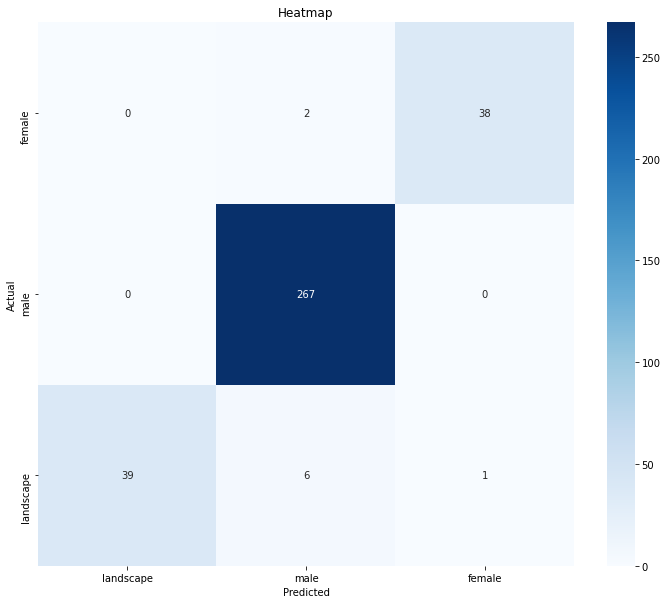

In [108]:
get_classification_results(y_test, y_test_pred,class_names)

#### Clasificador datos centrados en media
Realizamos el mismo proceso con los datos representados usando la técnica original del paper de Zhao, y mostramos los resultados de usar un clasificador no paramétrico.

In [109]:
y_val_pred = mean_center_rand_forest.predict(X_val_p)

##### Resultados en conjunto de validación

Accuracy: 0.984375
Precision for class landscape: 1.0
Precision for class male: 0.9797421731123389
Precision for class female: 1.0
              precision    recall  f1-score   support

   landscape       1.00      0.88      0.94        92
        male       0.98      1.00      0.99       532
      female       1.00      1.00      1.00        80

    accuracy                           0.98       704
   macro avg       0.99      0.96      0.98       704
weighted avg       0.98      0.98      0.98       704



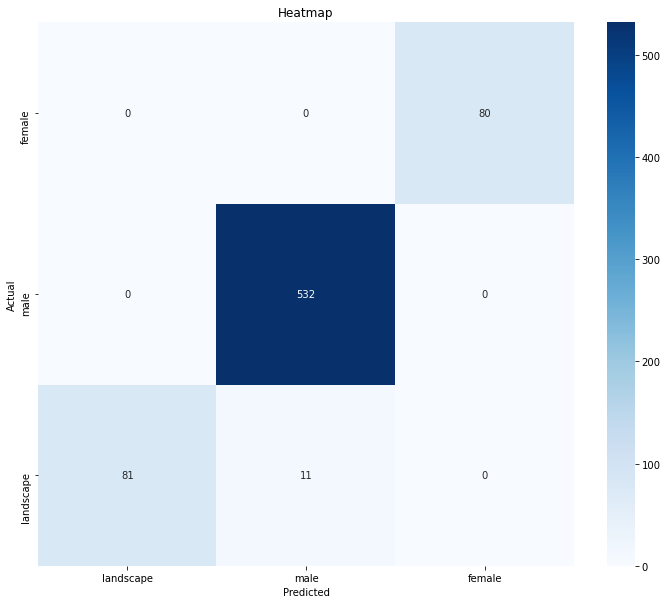

In [110]:
get_classification_results(y_val, y_val_pred,class_names)

In [111]:
y_test_pred = mean_center_rand_forest.predict(X_test_p)

##### Resultados en conjunto de prueba

Accuracy: 0.9631728045325779
Precision for class landscape: 1.0
Precision for class male: 0.9535714285714286
Precision for class female: 1.0
              precision    recall  f1-score   support

   landscape       1.00      0.78      0.88        46
        male       0.95      1.00      0.98       267
      female       1.00      0.93      0.96        40

    accuracy                           0.96       353
   macro avg       0.98      0.90      0.94       353
weighted avg       0.96      0.96      0.96       353



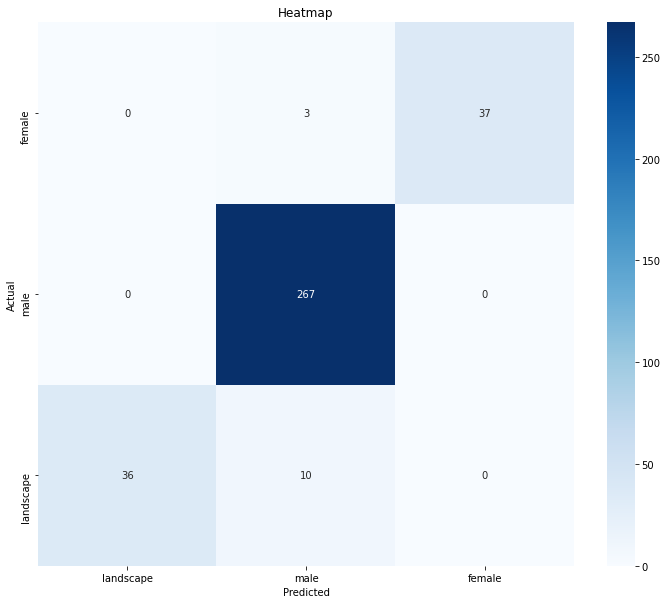

In [112]:
get_classification_results(y_test, y_test_pred,class_names)

#### Clasificador datos centrados en mediana

Para éste conjunto de datos se presentaron las métricas mejor ajustadas del proceso de clasificación, lo cual indica que éste proceso no paramétrico aprovecha la información subyacente dentro del conjunto de datos, sin realizar suposiciones más que del balanceo de clases que se observa para este conjunto.

In [113]:
y_val_pred = median_center_rand_forest.predict(X_val_m)

##### Resultados en conjunto de validación

Accuracy: 0.9857954545454546
Precision for class landscape: 1.0
Precision for class male: 0.981549815498155
Precision for class female: 1.0
              precision    recall  f1-score   support

   landscape       1.00      0.91      0.95        92
        male       0.98      1.00      0.99       532
      female       1.00      0.97      0.99        80

    accuracy                           0.99       704
   macro avg       0.99      0.96      0.98       704
weighted avg       0.99      0.99      0.99       704



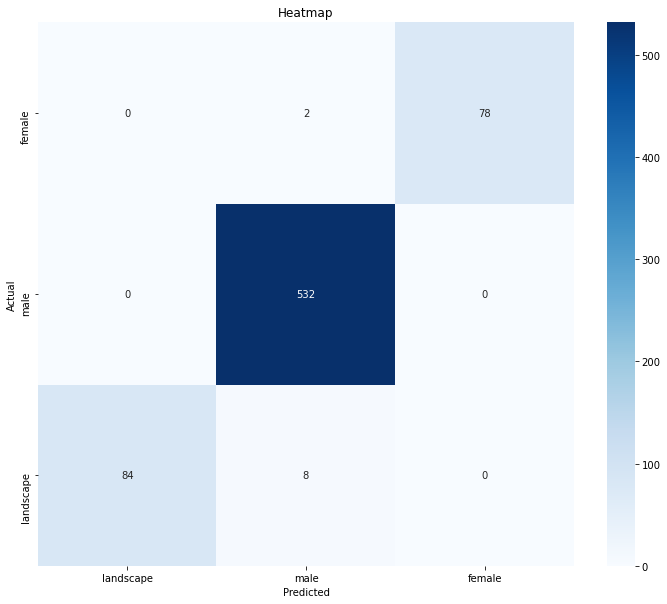

In [114]:
get_classification_results(y_val, y_val_pred,class_names)

In [115]:
y_test_pred = median_center_rand_forest.predict(X_test_m)

##### Resultados en conjunto de prueba

Accuracy: 0.9745042492917847
Precision for class landscape: 1.0
Precision for class male: 0.967391304347826
Precision for class female: 1.0
              precision    recall  f1-score   support

   landscape       1.00      0.87      0.93        46
        male       0.97      1.00      0.98       267
      female       1.00      0.93      0.96        40

    accuracy                           0.97       353
   macro avg       0.99      0.93      0.96       353
weighted avg       0.98      0.97      0.97       353



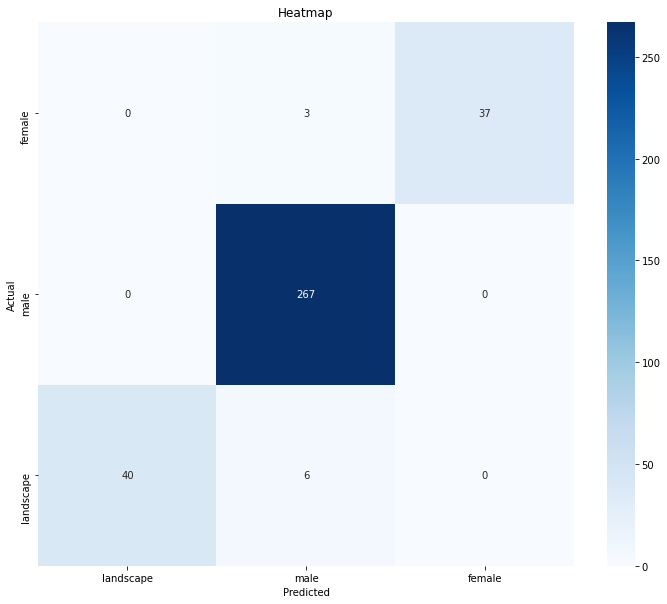

In [116]:
get_classification_results(y_test, y_test_pred,class_names)

#### Clasificador robusto

Similar a su contraparte con centralización en la mediana, éste conjunto presenta una serie de métricas muy ajustadas. Sin embargo, éstas no superan a aquellas obtenidas en el espacio de datos anterior.

In [117]:
y_val_pred = robust_cov_rand_forest.predict(X_val_s)

##### Resultados en conjunto de validación

Accuracy: 0.9744318181818182
Precision for class landscape: 0.9868421052631579
Precision for class male: 0.9725274725274725
Precision for class female: 0.975609756097561
              precision    recall  f1-score   support

   landscape       0.99      0.82      0.89        92
        male       0.97      1.00      0.99       532
      female       0.98      1.00      0.99        80

    accuracy                           0.97       704
   macro avg       0.98      0.94      0.96       704
weighted avg       0.97      0.97      0.97       704



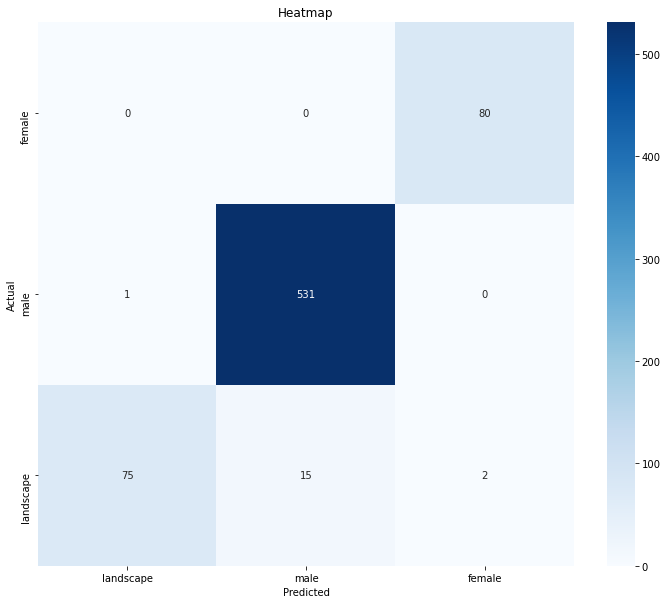

In [118]:
get_classification_results(y_val, y_val_pred,class_names)

In [119]:
y_test_pred = robust_cov_rand_forest.predict(X_test_s)

##### Resultados en conjunto de prueba

Accuracy: 0.9660056657223796
Precision for class landscape: 0.9722222222222222
Precision for class male: 0.967391304347826
Precision for class female: 0.9512195121951219
              precision    recall  f1-score   support

   landscape       0.97      0.76      0.85        46
        male       0.97      1.00      0.98       267
      female       0.95      0.97      0.96        40

    accuracy                           0.97       353
   macro avg       0.96      0.91      0.93       353
weighted avg       0.97      0.97      0.96       353



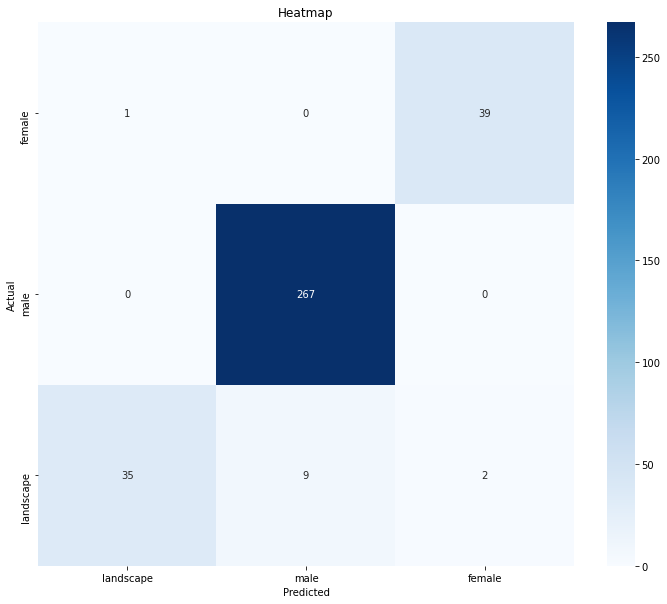

In [120]:
get_classification_results(y_test, y_test_pred,class_names)

# 4. Resultados

Se observa que los clasificadores usando los datos originales obtienen unos resultados sorprendéntemente buenos a pesar de su alta dimensionalidad. Esto puede darse debido a la información espacial que corresponde a los cálculos entre áreas de pixeles y sus respectivas distancias. A pesar de ser computaciones con alto costo, se observa una muy buena clasificación. Se debe mencionar también el éxito de los clasificadores no paramétricos en los espacios de datos que corresponden a sus matrices no paramétricas.

Se observan las tablas con resultados a continuación:

#### Exactitud						
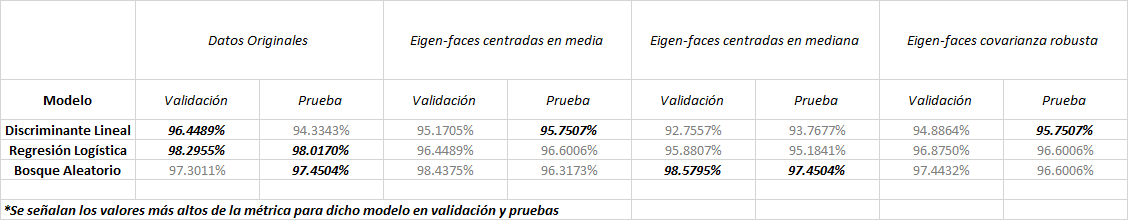

#### Precisión
						
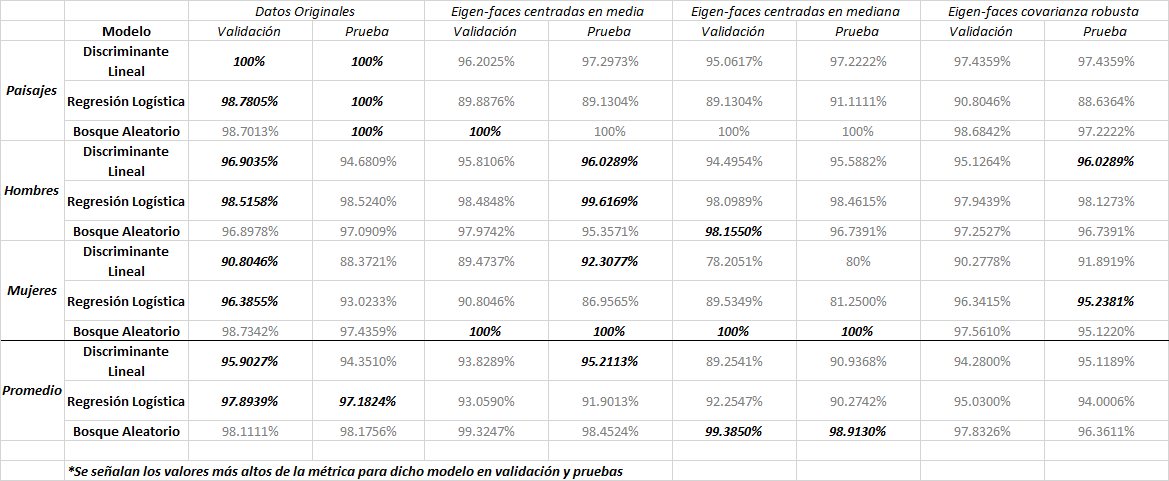

#### Exhaustividad (Recall)
						
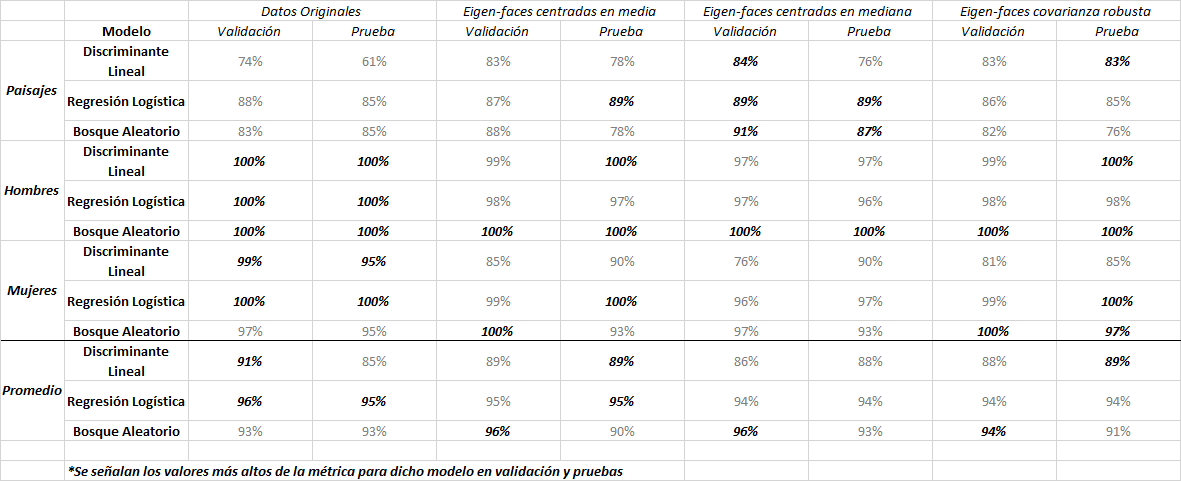

# 5. Conclusiones

- A pesar de la carga de multidimensionalidad, la información espacial que corresponde a los datos originales se mantiene respecto a los cálculos de distancia pixel a pixel entre cada imágen, por lo que los datos originales, a pesar de representar una serie de computaciones más costosas, conlleva a una de las mejores clasificaciones.
- Las pruebas no paramétricas de pertenencia a la misma población es un excelente determinante para los conjuntos de imágenes, dado que mantiene la información espacial por el cálculo de las distancias pixel a pixel.
- La representación en un espacio reducido, aunque puede llevar a tener unas métricas inferiores que al usar el espacio original, dados los métodos correctos puede llegar a alcanzar niveles de desempeño tolerables, tomando en cuenta la relación entre la reducción del espacio y la pérdida de información.
- Los modelos de clasificación no paramétricos responden de manera más apropiada que los modelos paramétricos, mostrando la robustez de los mismos y cómo estos se presentan balanceados a la hora de clasificar conjuntos de datos con desbalance de clases.
- Para una próxima investigación se sugiere explorar la creación de espacios de eigen-faces con distintas matrices de covarianza no paramétricas: Modificada por Ledoit-Wolff, Co-median, Máxima Kurtosis, etc.

# Referencias

1. W. Zhao, R. Chellappa, P. J. Phillips, and A Rosenfeld. Face Recognition: A Literature Survey.). ACM Comput. Surv., 35(4):399–458, 2003.

1. M. A. Turk and A. P. Pentland. Face recognition using eigenfaces. 1991 IEEE Computer Society Conference on Computer Vision and Pattern Recognition Proceedings, pp.586-591, 1991. https://doi.org/10.1109/CVPR.1991.139758.